# Linear regression, lambda KAN training on MNIST

In [1]:
import os
import sys

import torch
import torchmetrics
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.nn.modules.pooling import MaxPool2d
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, utils
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from IPython.display import clear_output

import torch
import torchmetrics
import lightning as L
import torch.nn as nn
import matplotlib.pyplot as plt

from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)
from lightning.pytorch.callbacks import ModelCheckpoint
from tbparse import SummaryReader

from kan import KANLayer
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from source import lmdKANLayer

import random

from models import MnistLR, MnistMLP, Mnist_lmdSplineKAN, Mnist_tlmdSplineKAN, show_sensitivity

c:\Users\Student\VSprojects_Gavr\lambda_KAN\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST):

In [2]:
batch_size = 256

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

mnist = datasets.MNIST(root="./", train=True, download=True, transform=transform)

(train_set, val_set,) = torch.utils.data.random_split(
    mnist, [50000, 10000], generator=torch.Generator().manual_seed(42)
)
test_set = datasets.MNIST(root="./", train=False, download=True, transform=transform)

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

### Create LightningModule class

In [3]:
class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        self.save_hyperparameters(logger=False)

        # for optimizer and shaduler
        self.lr = lr

        # model
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

        # metrics
        self.metrics = MetricCollection([
            MulticlassAccuracy(num_classes=10,),
            #MulticlassF1Score(num_classes=10,),
            #MulticlassAUROC(num_classes=10,)
        ])
        self.train_metrics = self.metrics.clone(postfix='/train')
        self.val_metrics = self.metrics.clone(postfix='/val')

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss" # only for self.log
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out, y)
        self.log("loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

### Start training

#### MnistLR

Seed set to 1755
c:\Users\Student\VSprojects_Gavr\lambda_KAN\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MnistLR          | 7.9 K  | train
1 |

Epoch 0: 100%|██████████| 196/196 [00:05<00:00, 34.12it/s, v_num=0, loss=0.541]Shape with bias: (784, 10)


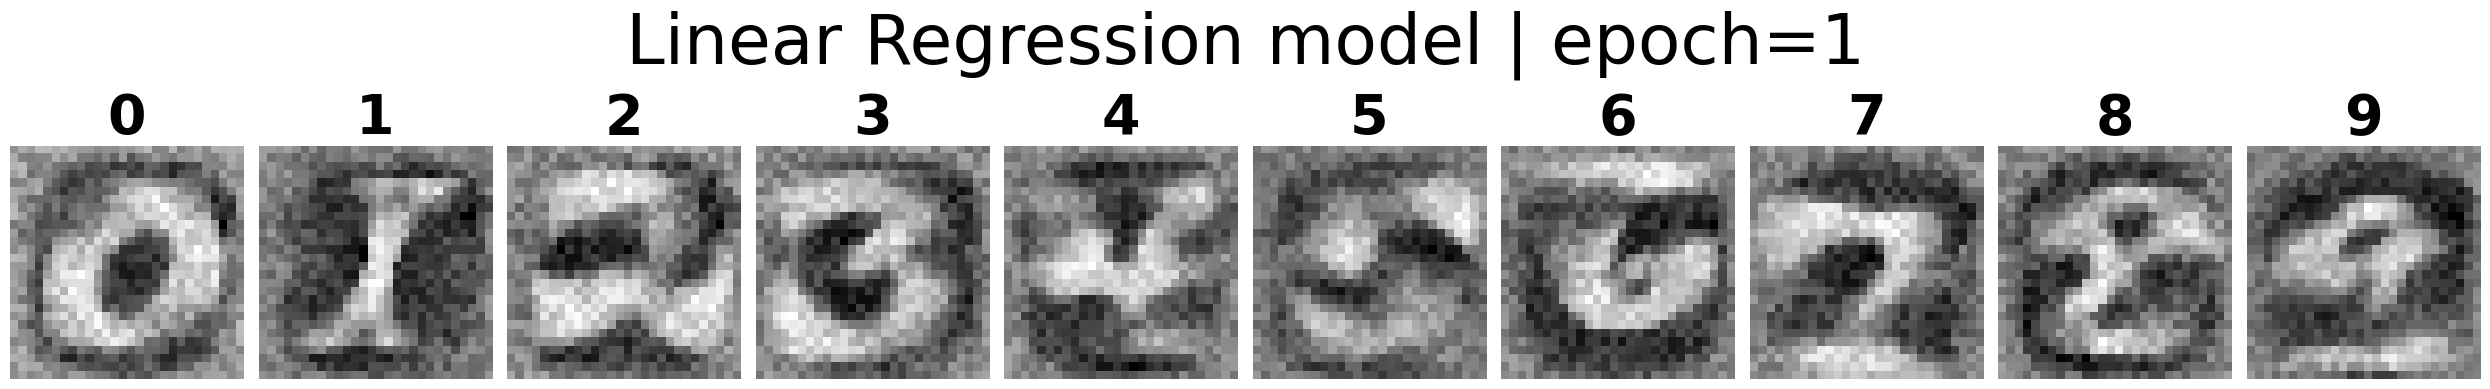

Epoch 1: 100%|██████████| 196/196 [00:02<00:00, 65.82it/s, v_num=0, loss=0.331]Shape with bias: (784, 10)


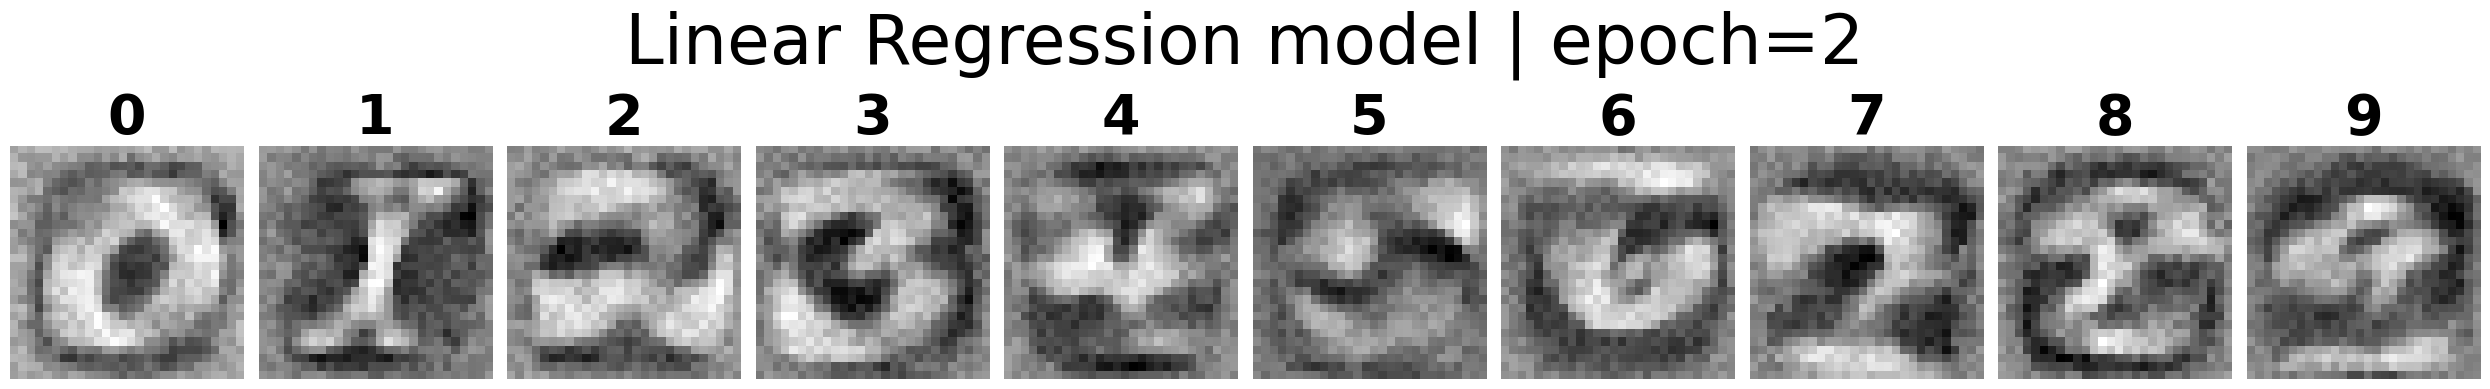

Epoch 2: 100%|██████████| 196/196 [00:03<00:00, 65.03it/s, v_num=0, loss=0.314]Shape with bias: (784, 10)


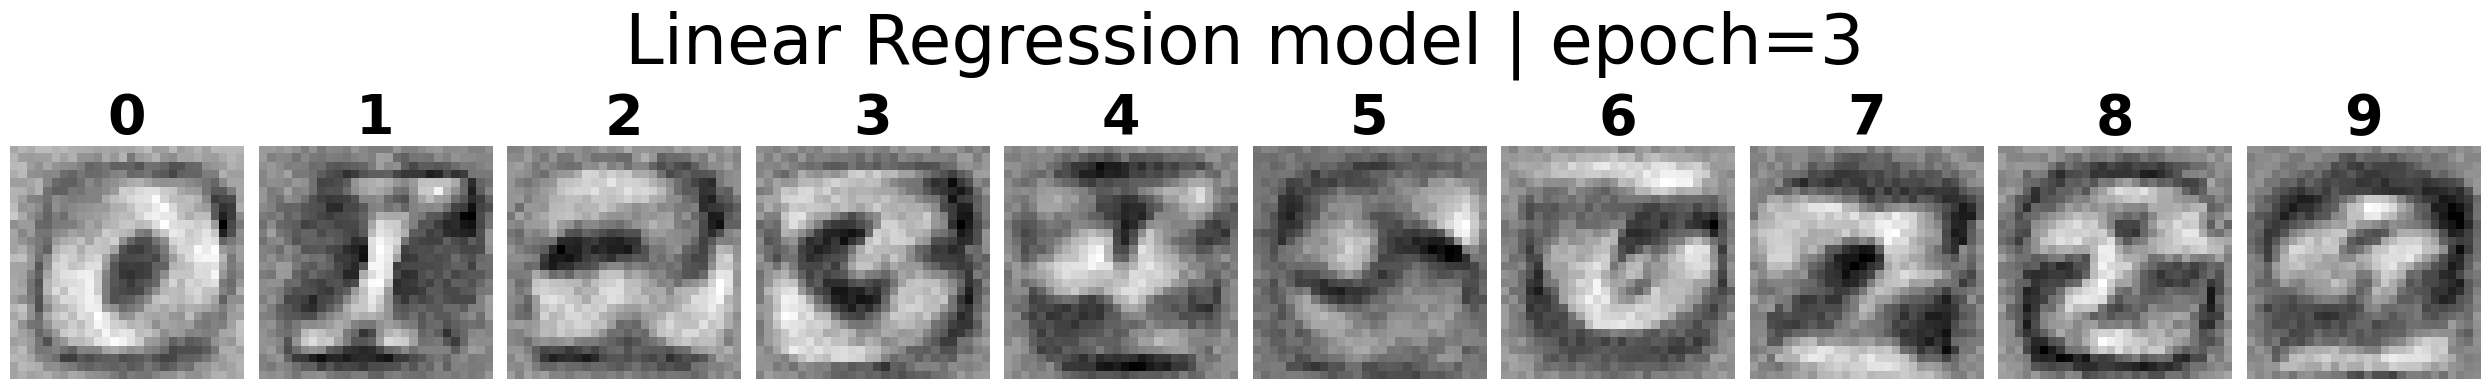

Epoch 3: 100%|██████████| 196/196 [00:02<00:00, 65.64it/s, v_num=0, loss=0.280]Shape with bias: (784, 10)


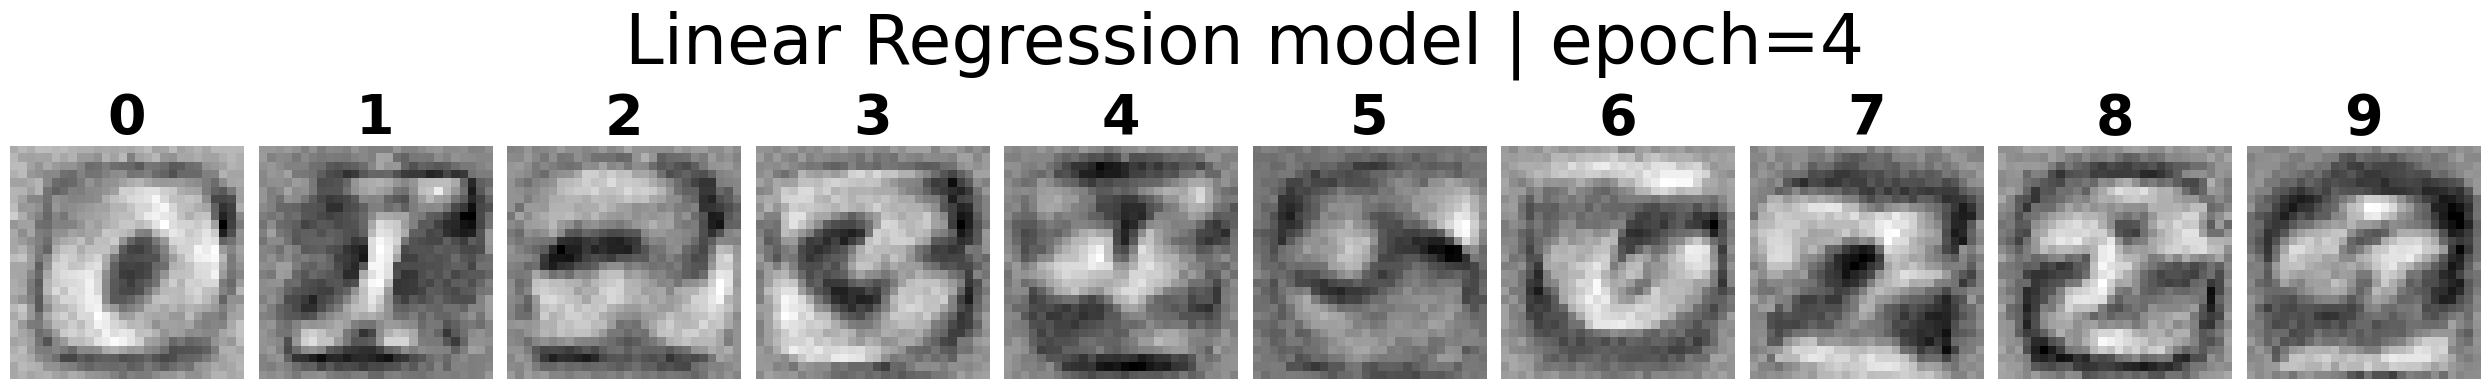

Epoch 4: 100%|██████████| 196/196 [00:02<00:00, 65.86it/s, v_num=0, loss=0.353]Shape with bias: (784, 10)


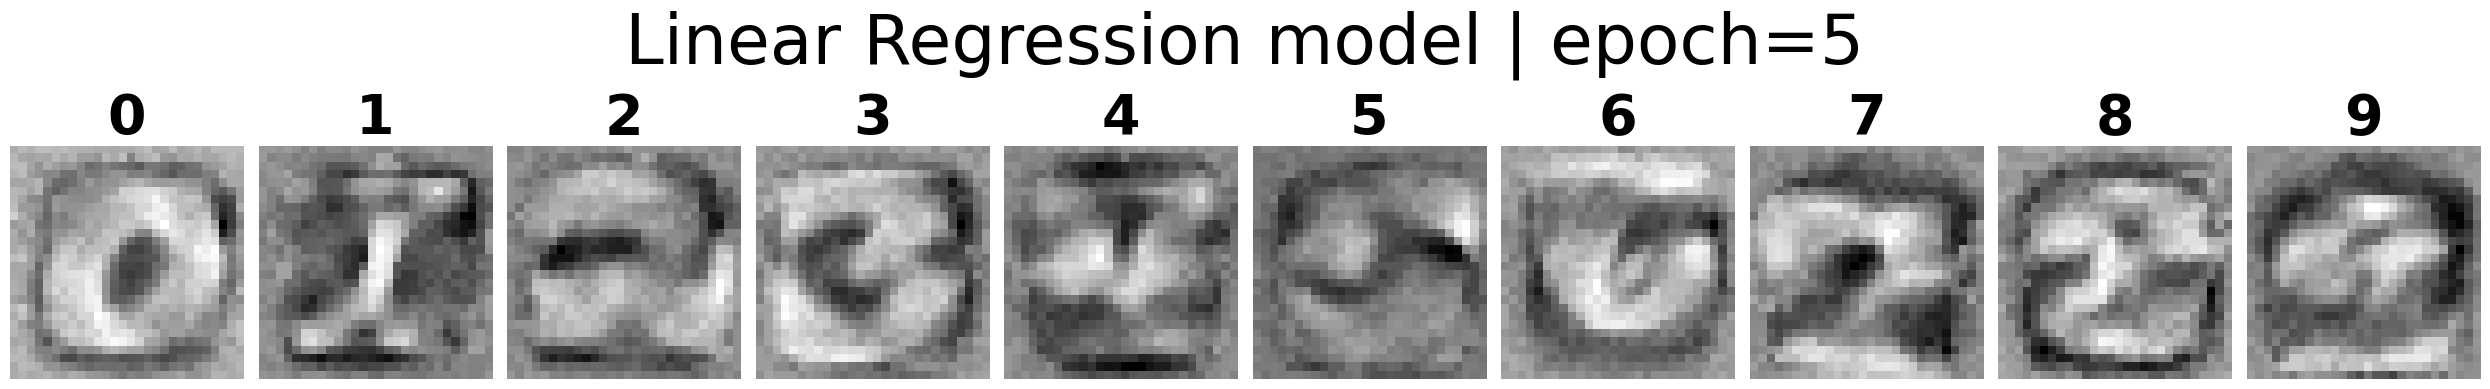

Epoch 5: 100%|██████████| 196/196 [00:02<00:00, 66.60it/s, v_num=0, loss=0.283]Shape with bias: (784, 10)


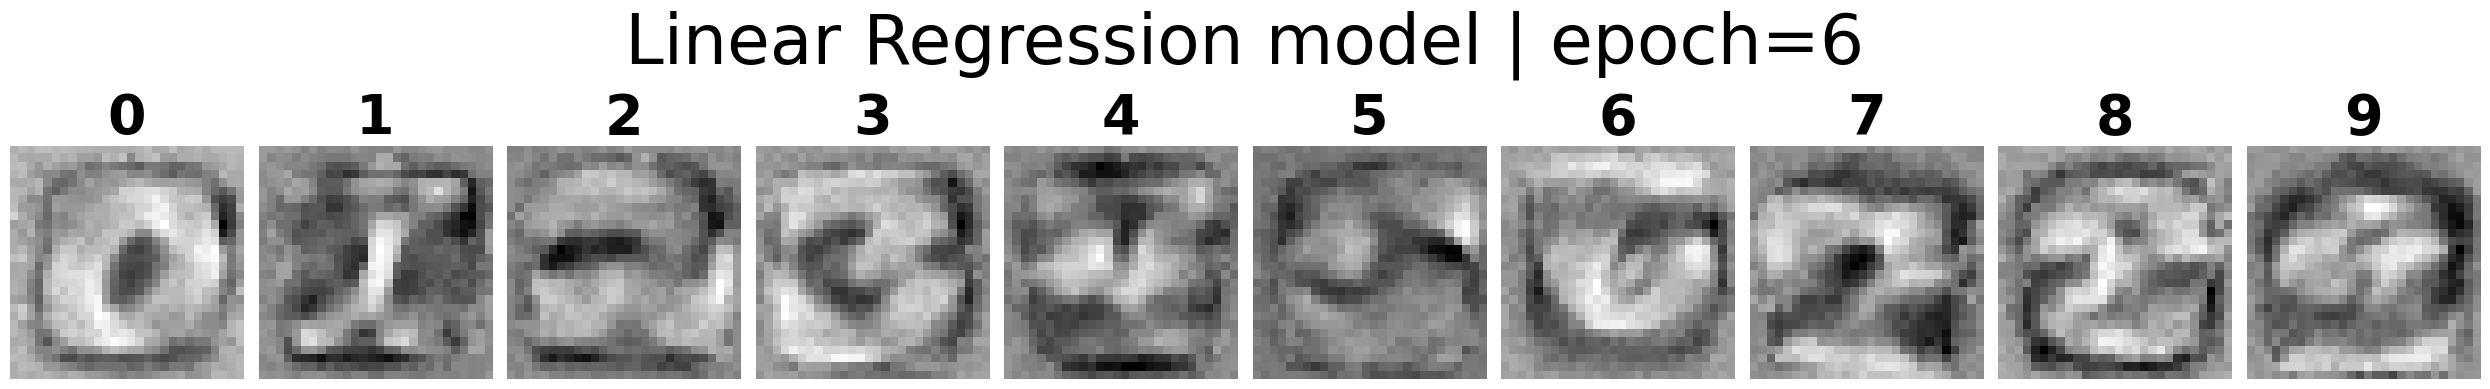

Epoch 6: 100%|██████████| 196/196 [00:02<00:00, 67.66it/s, v_num=0, loss=0.180]Shape with bias: (784, 10)


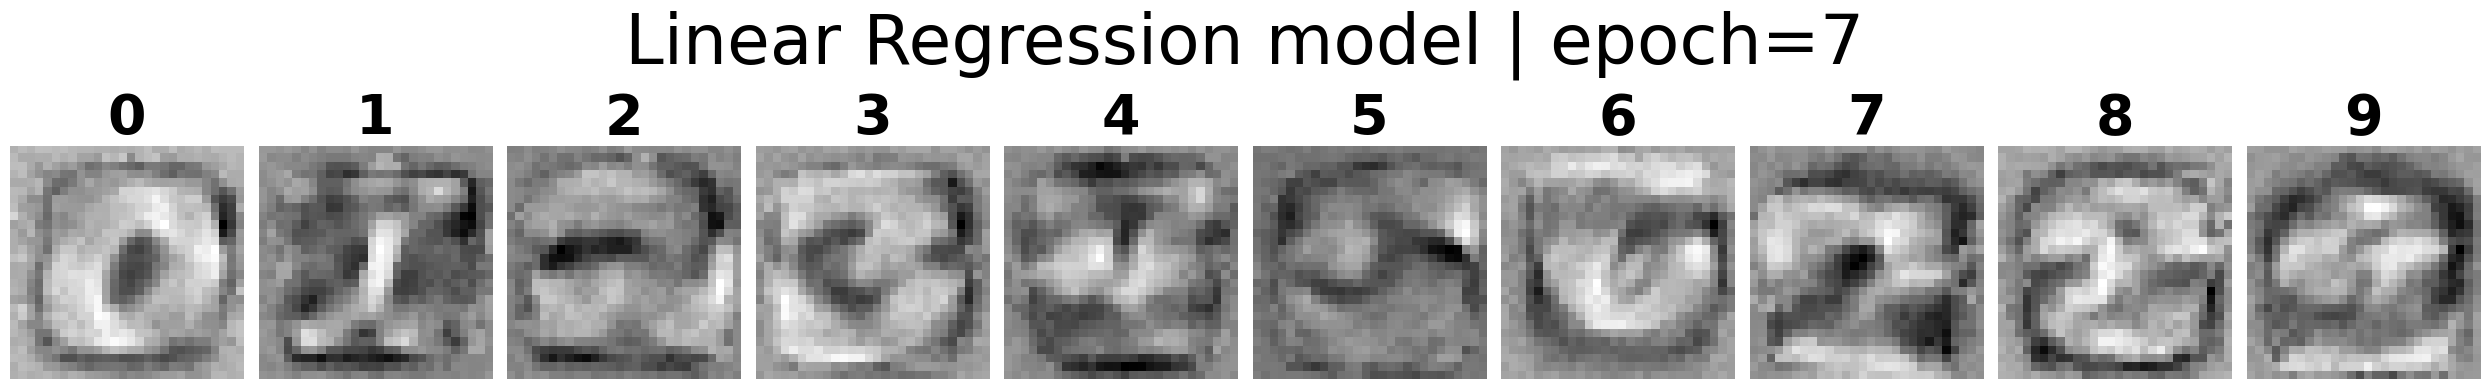

Epoch 7: 100%|██████████| 196/196 [00:02<00:00, 66.19it/s, v_num=0, loss=0.256]Shape with bias: (784, 10)


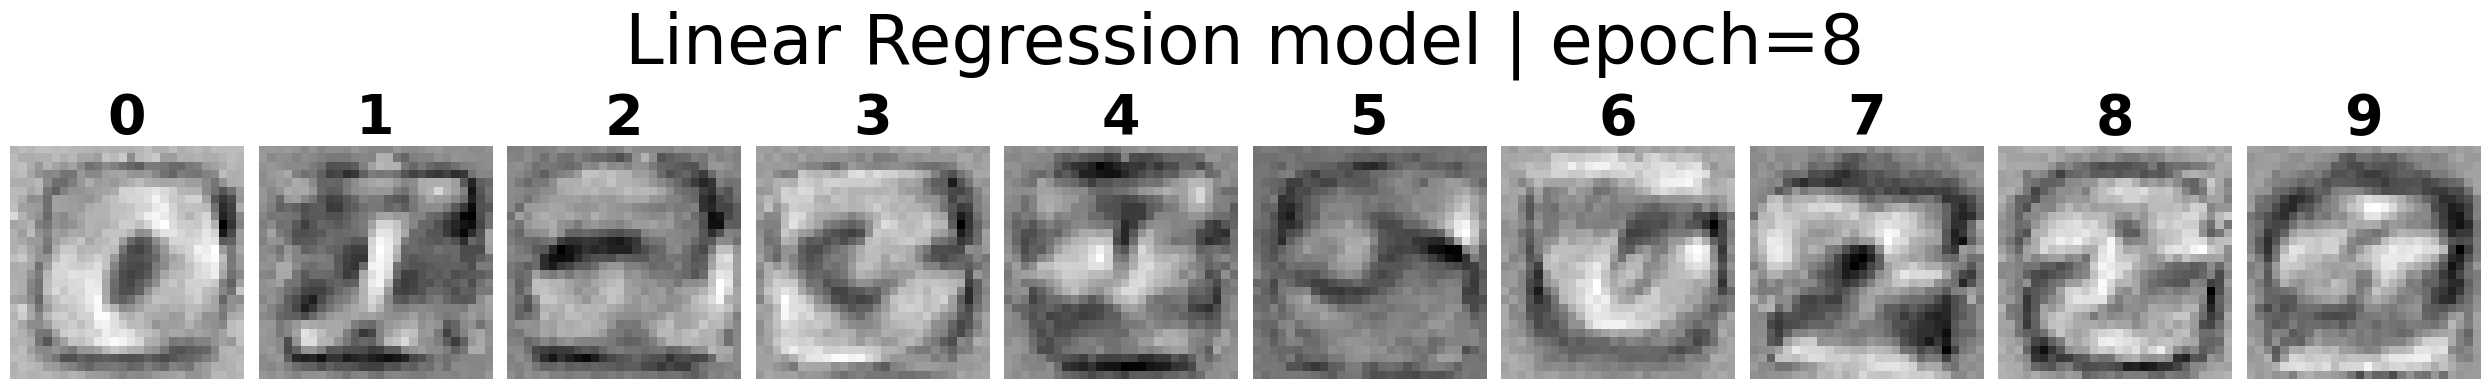

Epoch 8: 100%|██████████| 196/196 [00:02<00:00, 67.70it/s, v_num=0, loss=0.302]Shape with bias: (784, 10)


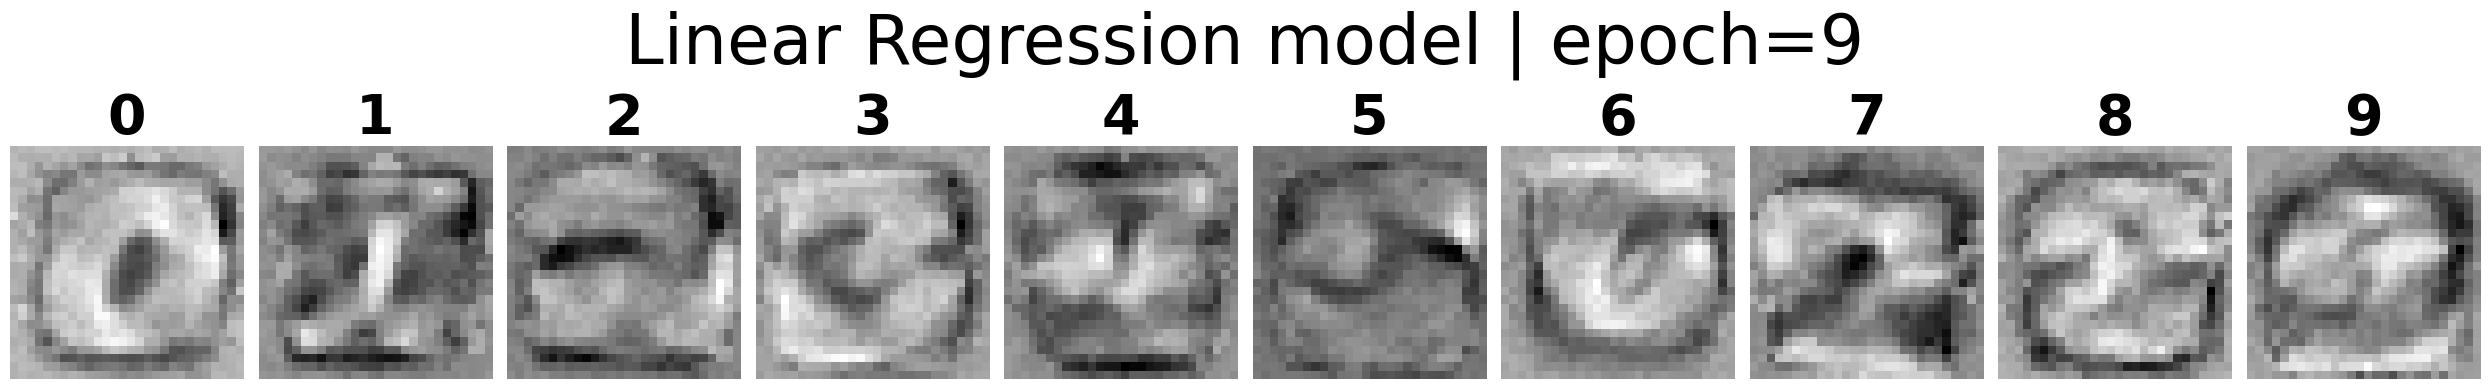

Epoch 9: 100%|██████████| 196/196 [00:02<00:00, 67.54it/s, v_num=0, loss=0.232]Shape with bias: (784, 10)


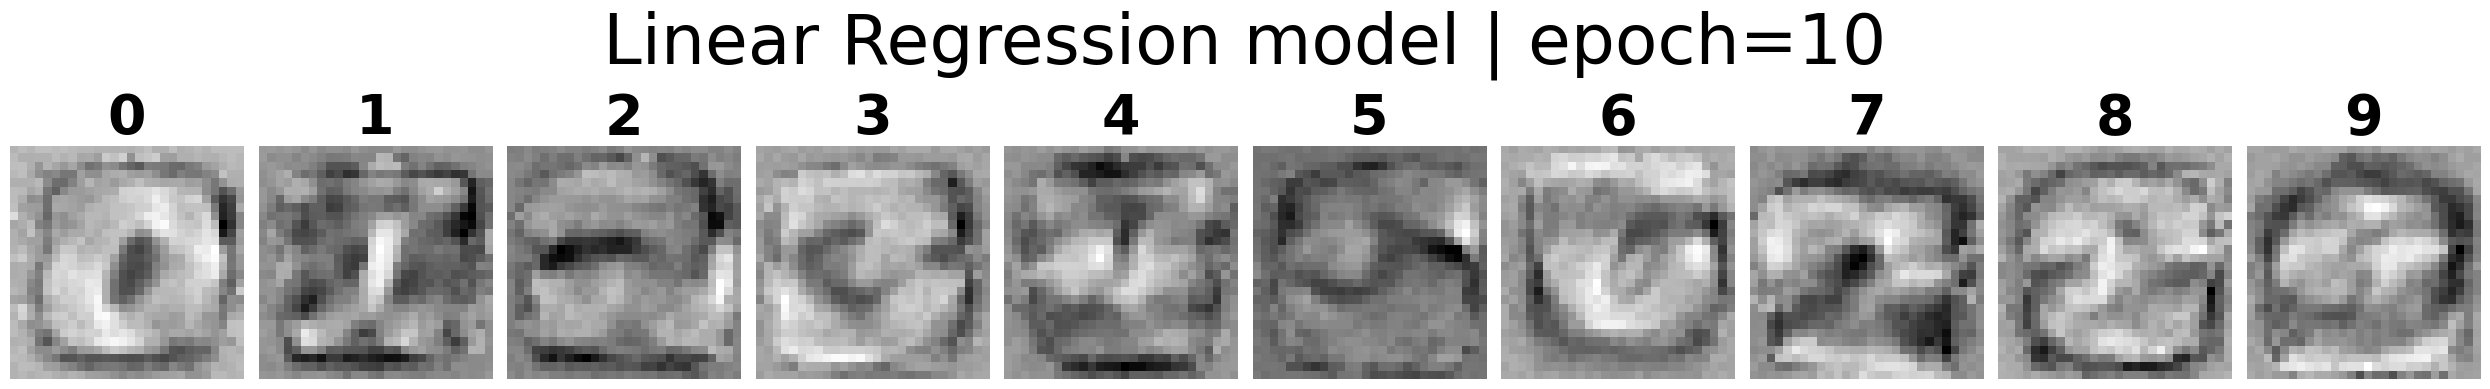

Epoch 10: 100%|██████████| 196/196 [00:02<00:00, 66.85it/s, v_num=0, loss=0.178]Shape with bias: (784, 10)


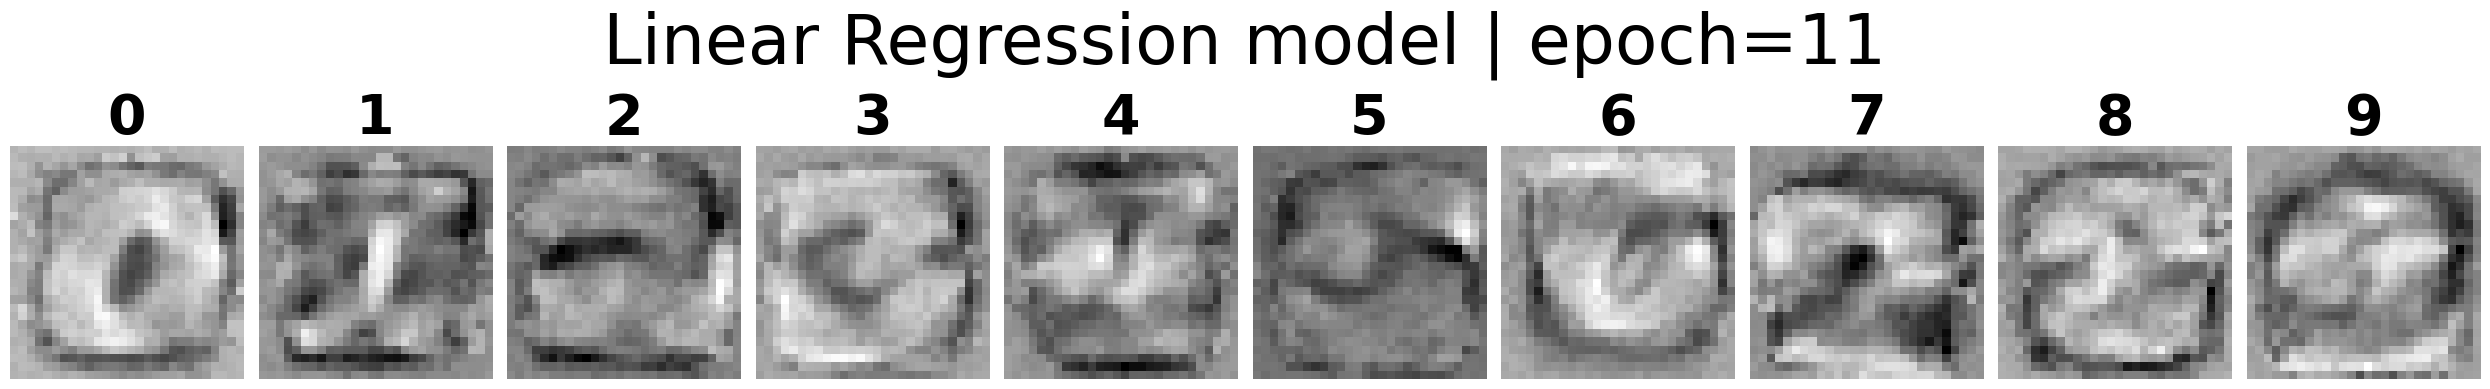

Epoch 11: 100%|██████████| 196/196 [00:02<00:00, 66.42it/s, v_num=0, loss=0.161]Shape with bias: (784, 10)


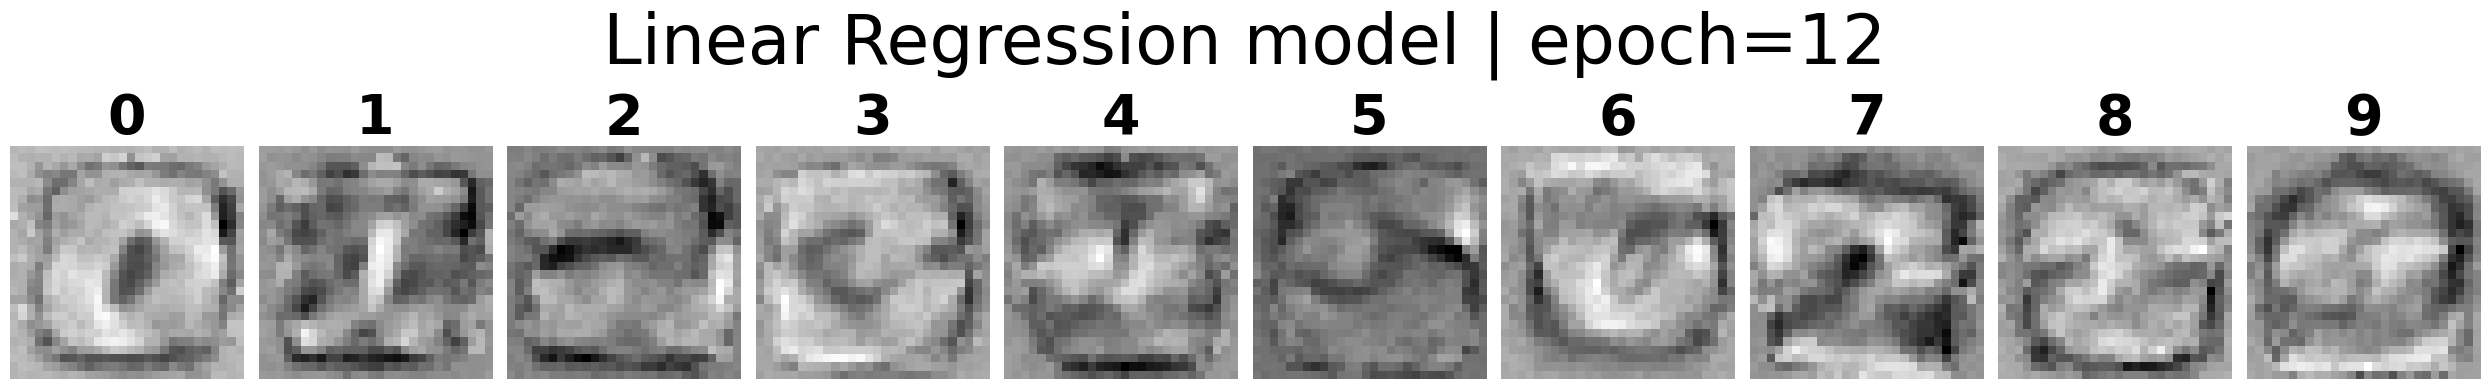

Epoch 12: 100%|██████████| 196/196 [00:02<00:00, 67.98it/s, v_num=0, loss=0.240]Shape with bias: (784, 10)


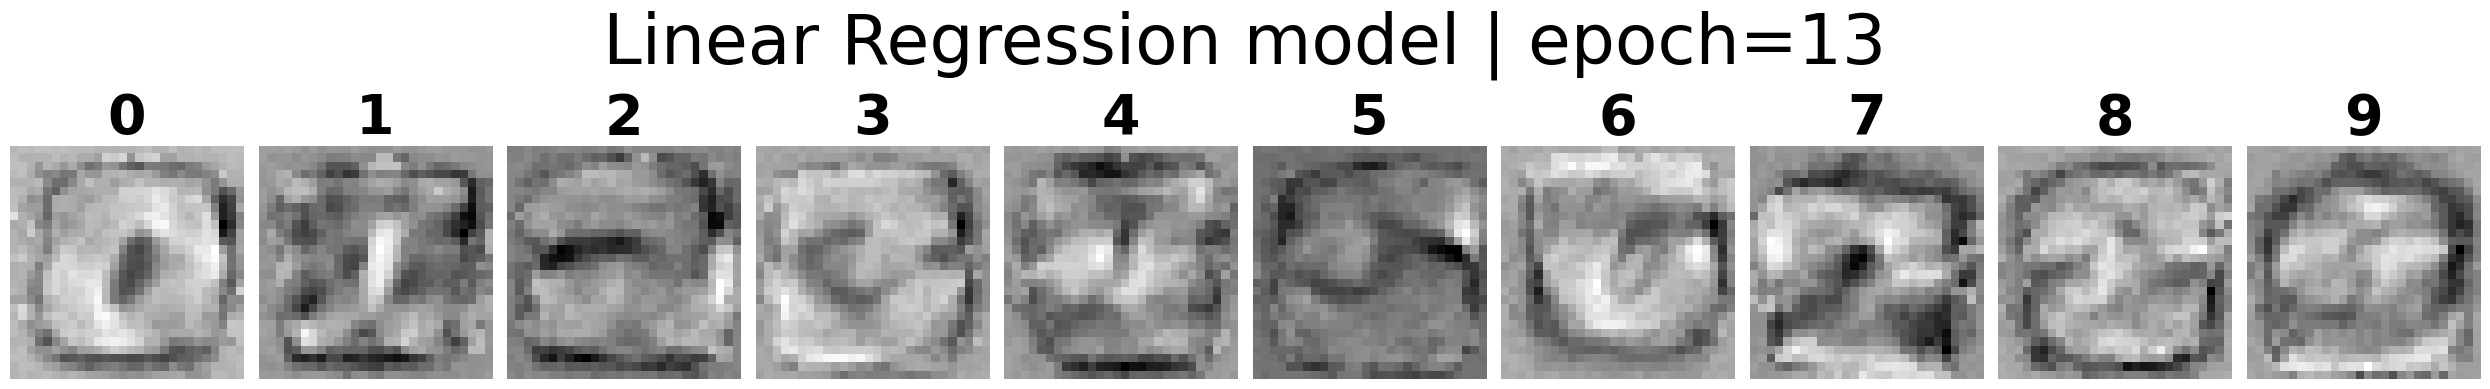

Epoch 13: 100%|██████████| 196/196 [00:02<00:00, 65.46it/s, v_num=0, loss=0.344]Shape with bias: (784, 10)


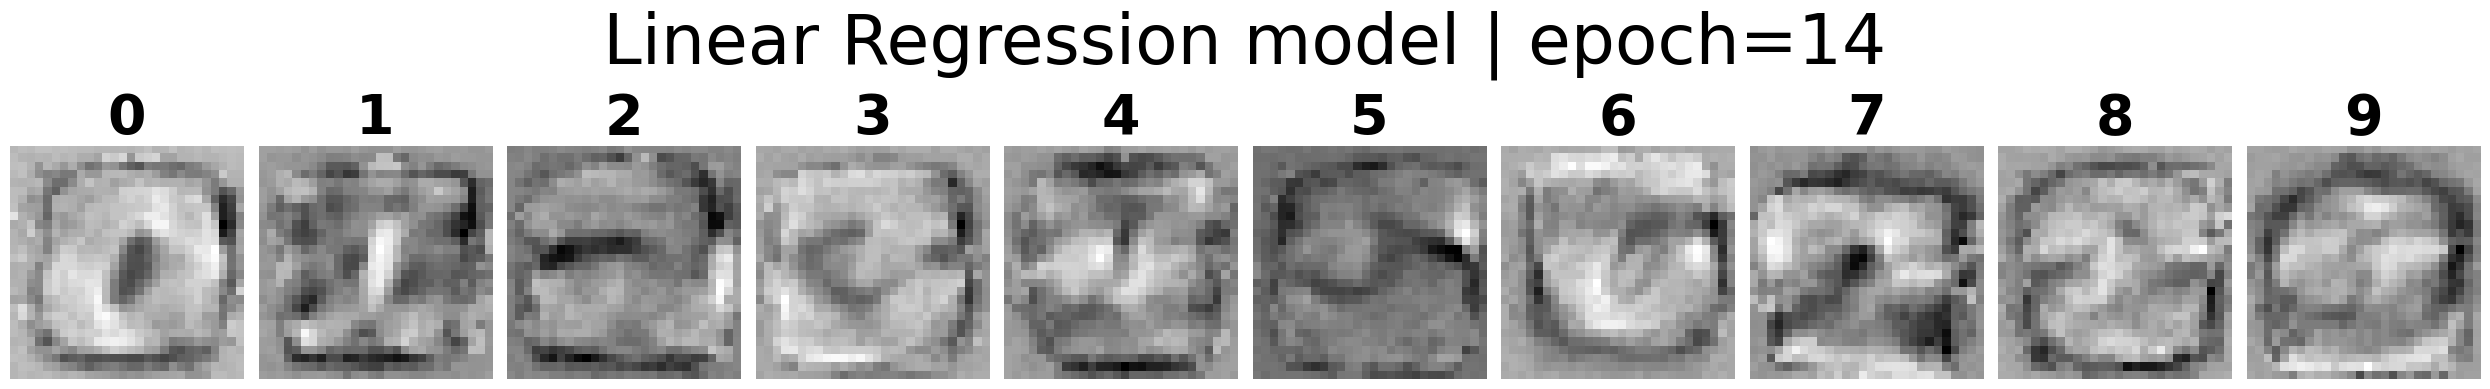

Epoch 14: 100%|██████████| 196/196 [00:02<00:00, 66.62it/s, v_num=0, loss=0.358]Shape with bias: (784, 10)


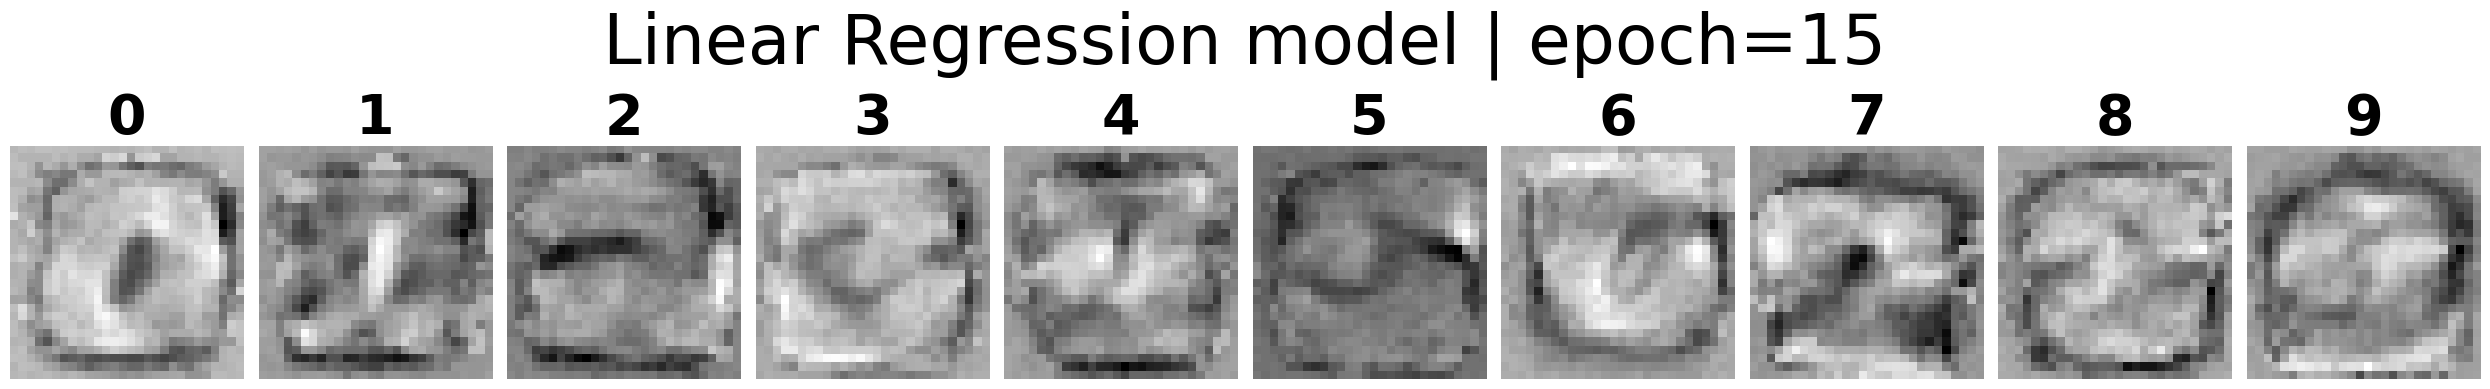

Epoch 15: 100%|██████████| 196/196 [00:02<00:00, 66.60it/s, v_num=0, loss=0.476]Shape with bias: (784, 10)


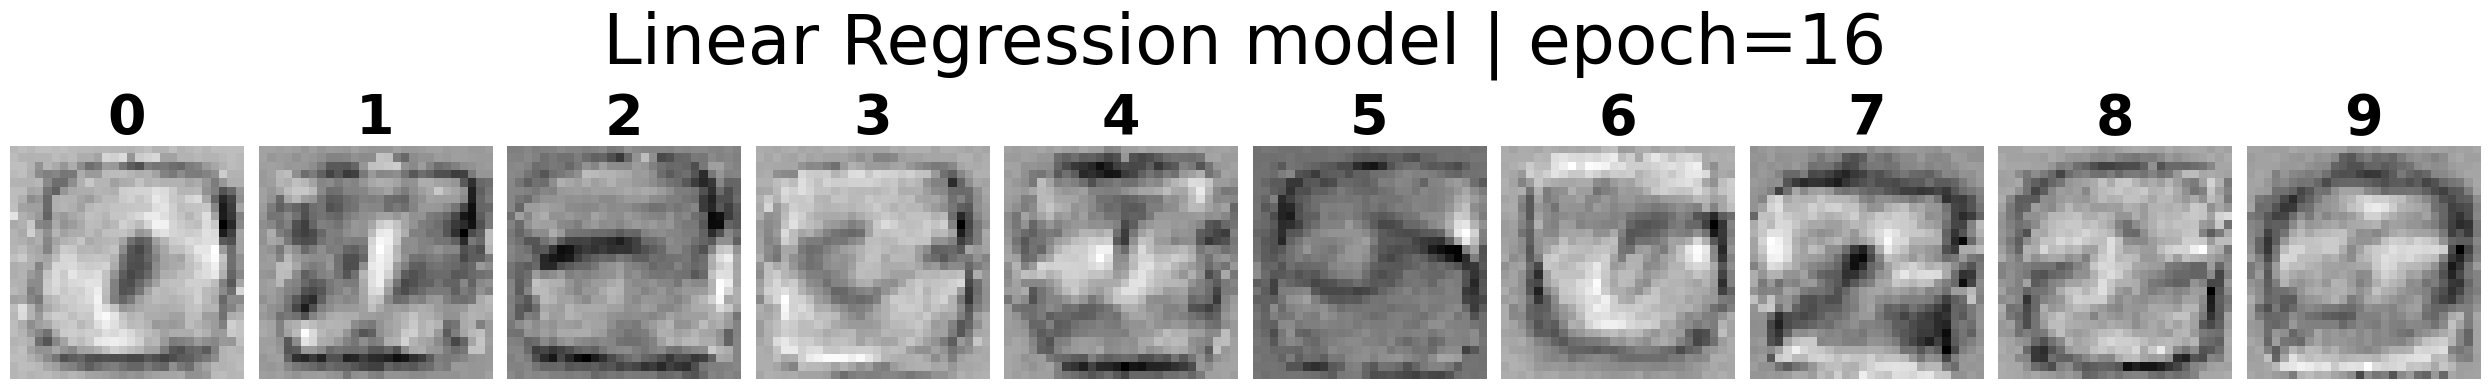

Epoch 16: 100%|██████████| 196/196 [00:02<00:00, 67.63it/s, v_num=0, loss=0.156]Shape with bias: (784, 10)


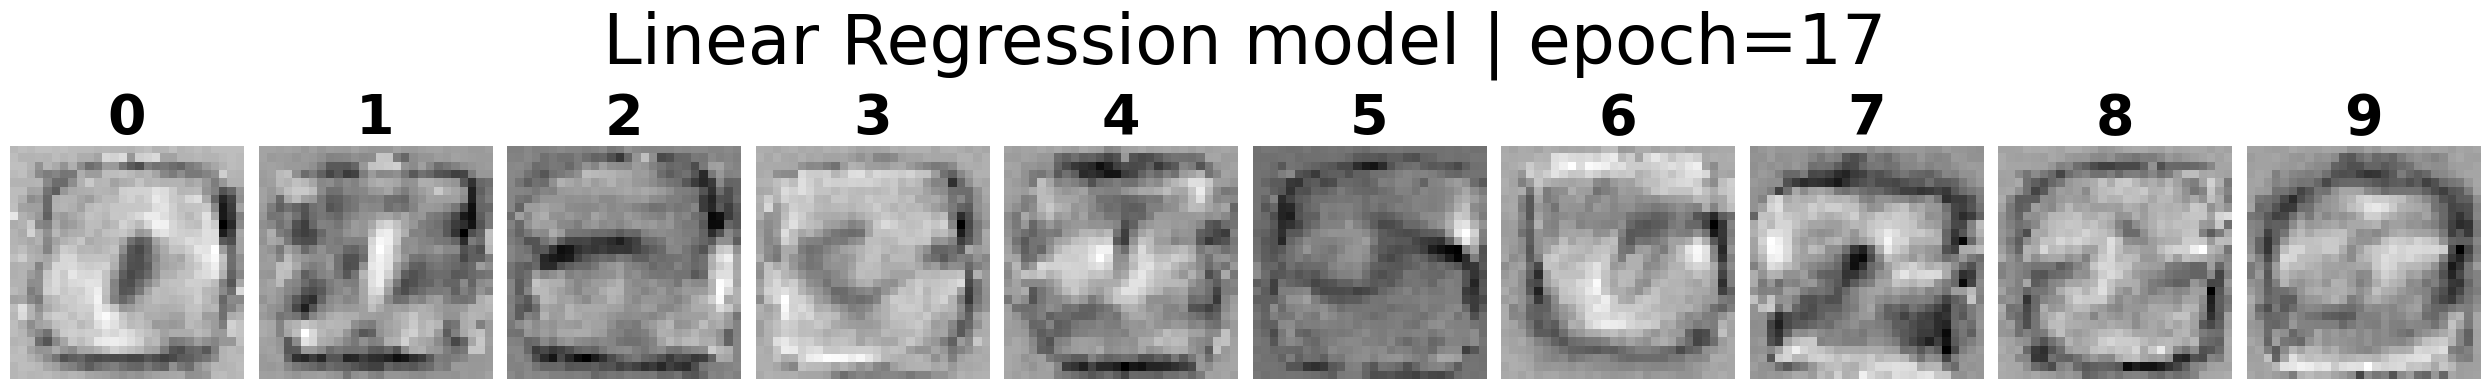

Epoch 17: 100%|██████████| 196/196 [00:03<00:00, 64.84it/s, v_num=0, loss=0.133]Shape with bias: (784, 10)


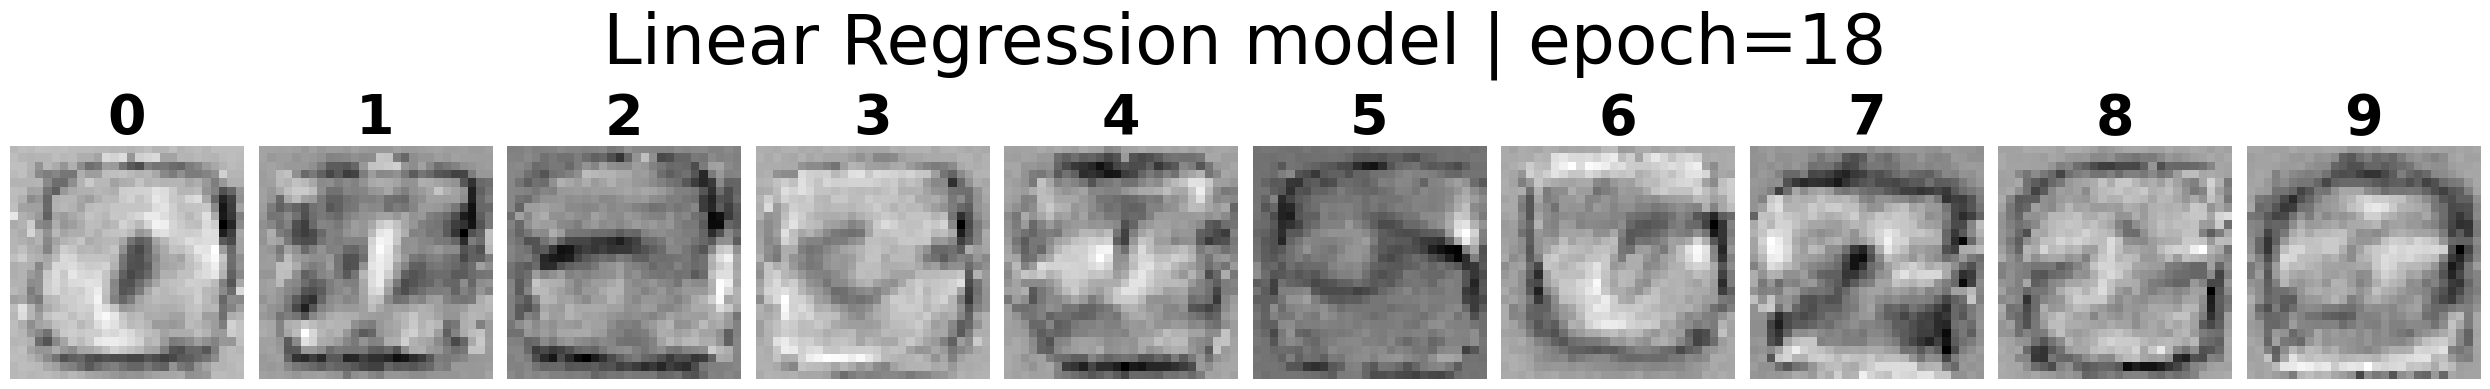

Epoch 18: 100%|██████████| 196/196 [00:02<00:00, 66.83it/s, v_num=0, loss=0.440]Shape with bias: (784, 10)


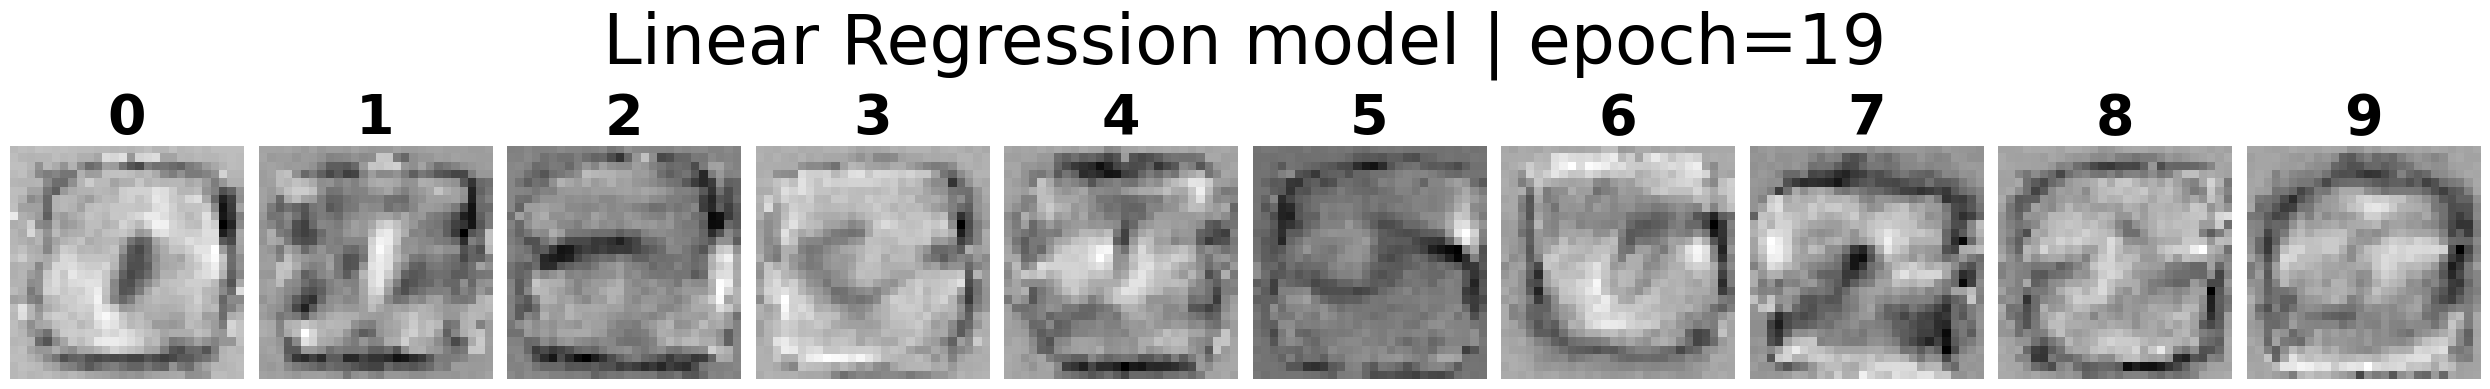

Epoch 19: 100%|██████████| 196/196 [00:02<00:00, 65.71it/s, v_num=0, loss=0.279]Shape with bias: (784, 10)


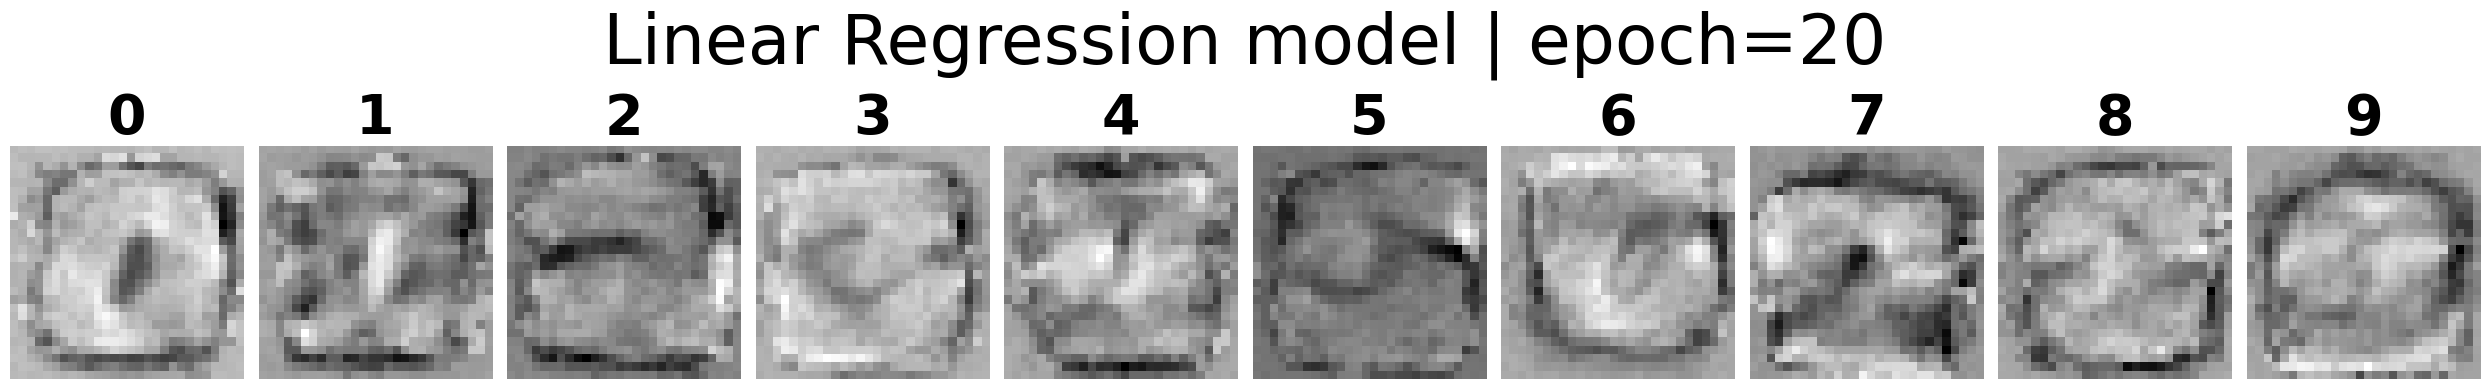

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 196/196 [00:03<00:00, 56.32it/s, v_num=0, loss=0.279]


In [4]:
class LModel_save_pic(LModel):
    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()
        
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        
        directory = self.logger.log_dir + '\\sens_pic'
        if not os.path.exists(directory):
            os.makedirs(directory)
        show_sensitivity(W = self.model.get_W(),
                         title = f'Linear Regression model | epoch={self.current_epoch+1}',
                         save_pic=True, 
                         file_path=directory + f'\\{self.current_epoch}.png')

checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

L.seed_everything(1755)

model = MnistLR() #Mnist_lmdSplineKAN() #MnistPrllSplineKAN() #MnistSplineKAN() #MnistSplineKAN() #MnistKAN() #MnistMLP() #MnistCNN() #MnistLR()
pl_model = LModel_save_pic(model)
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir=f"./logs/{type(model).__name__}/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

In [5]:
# Load the best checkpoint automatically (lightning tracks this for you)
trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)

Restoring states from the checkpoint path at ./logs/MnistLR/lightning_logs\version_0\checkpoints\model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/MnistLR/lightning_logs\version_0\checkpoints\model.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 81.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.9249137043952942     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.9249137043952942}]

#### MnistMLP

In [6]:
checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

L.seed_everything(1755)

model = MnistMLP() #Mnist_lmdSplineKAN() #MnistPrllSplineKAN() #MnistSplineKAN() #MnistSplineKAN() #MnistKAN() #MnistMLP() #MnistCNN() #MnistLR()
pl_model = LModel(model)
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir=f"./logs/{type(model).__name__}/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

Seed set to 1755
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | MnistMLP         | 218 K  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | metrics       | MetricCollection | 0      | train
3 | train_metrics | MetricCollection | 0      | train
4 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.872     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 196/196 [00:03<00:00, 64.12it/s, v_num=0, loss=0.000893]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 196/196 [00:03<00:00, 63.68it/s, v_num=0, loss=0.000893]


In [7]:
# Load the best checkpoint automatically (lightning tracks this for you)
trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)

Restoring states from the checkpoint path at ./logs/MnistMLP/lightning_logs\version_0\checkpoints\model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/MnistMLP/lightning_logs\version_0\checkpoints\model.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 82.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │     0.979373574256897     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.979373574256897}]

#### Mnist_lmdSplineKAN

Seed set to 1755
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | Mnist_lmdSplineKAN | 537 K  | train
1 | criterion     | CrossEntropyLoss   | 0      | train
2 | metrics       | MetricCollection   | 0      | train
3 | train_metrics | MetricCollection   | 0      | train
4 | val_metrics   | MetricCollection   | 0      | train
-------------------------------------------------------------
35.4 K    Trainable params
502 K     Non-trainable params
537 K     Total params
2.152     Total estimated model params size (MB)
80        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 196/196 [00:28<00:00,  6.92it/s, v_num=0, loss=1.600]Shape with bias: (784, 10)


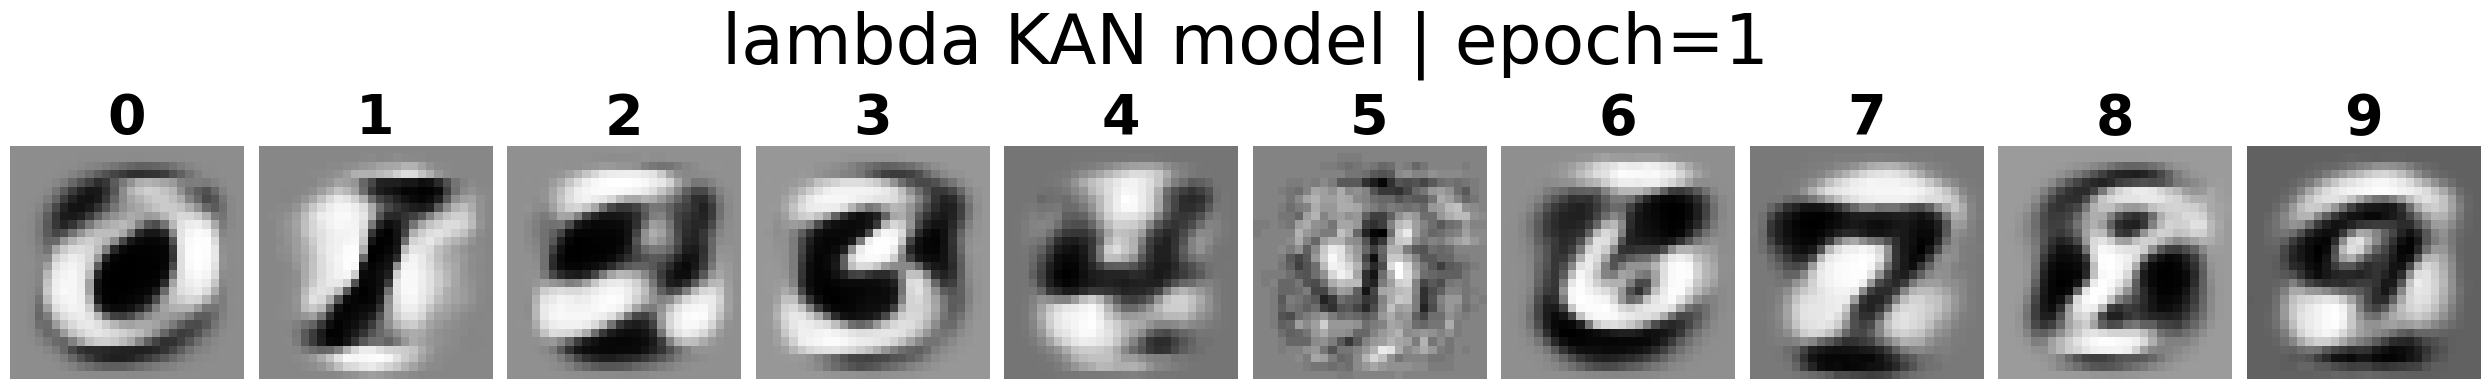

Epoch 1: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s, v_num=0, loss=0.959]Shape with bias: (784, 10)


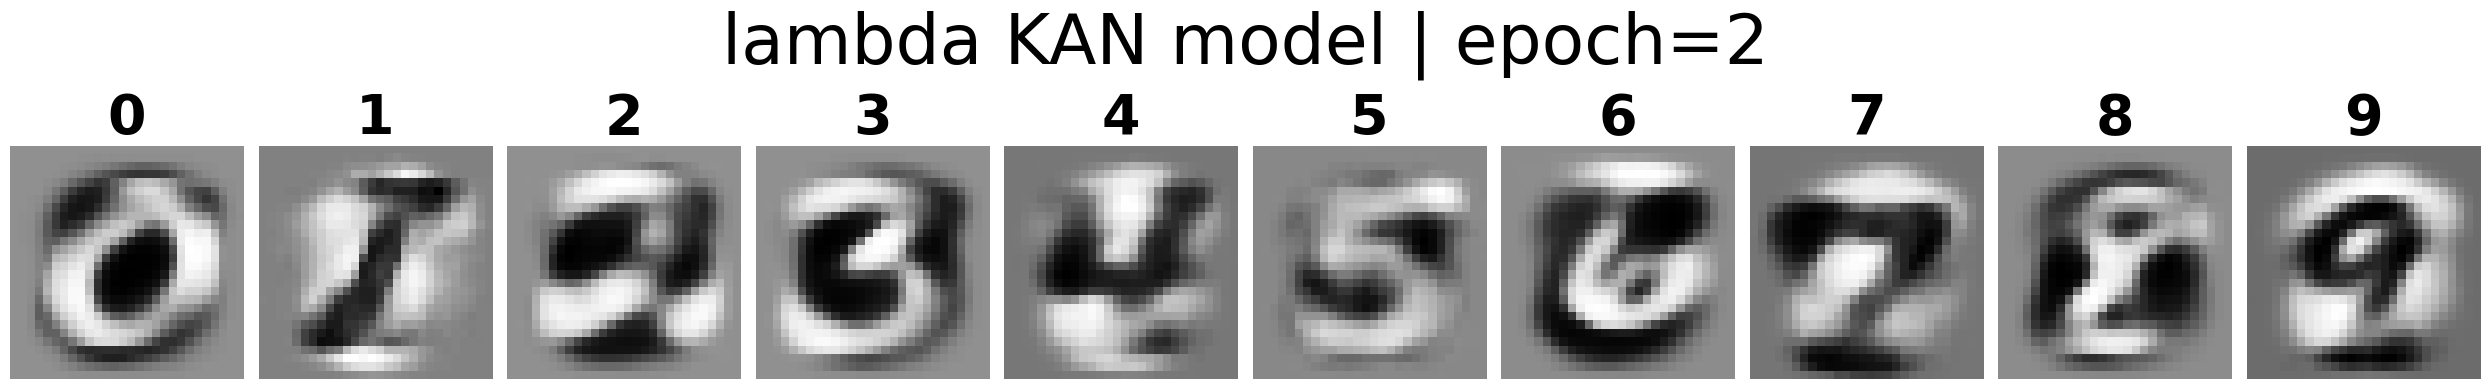

Epoch 2: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.866]Shape with bias: (784, 10)


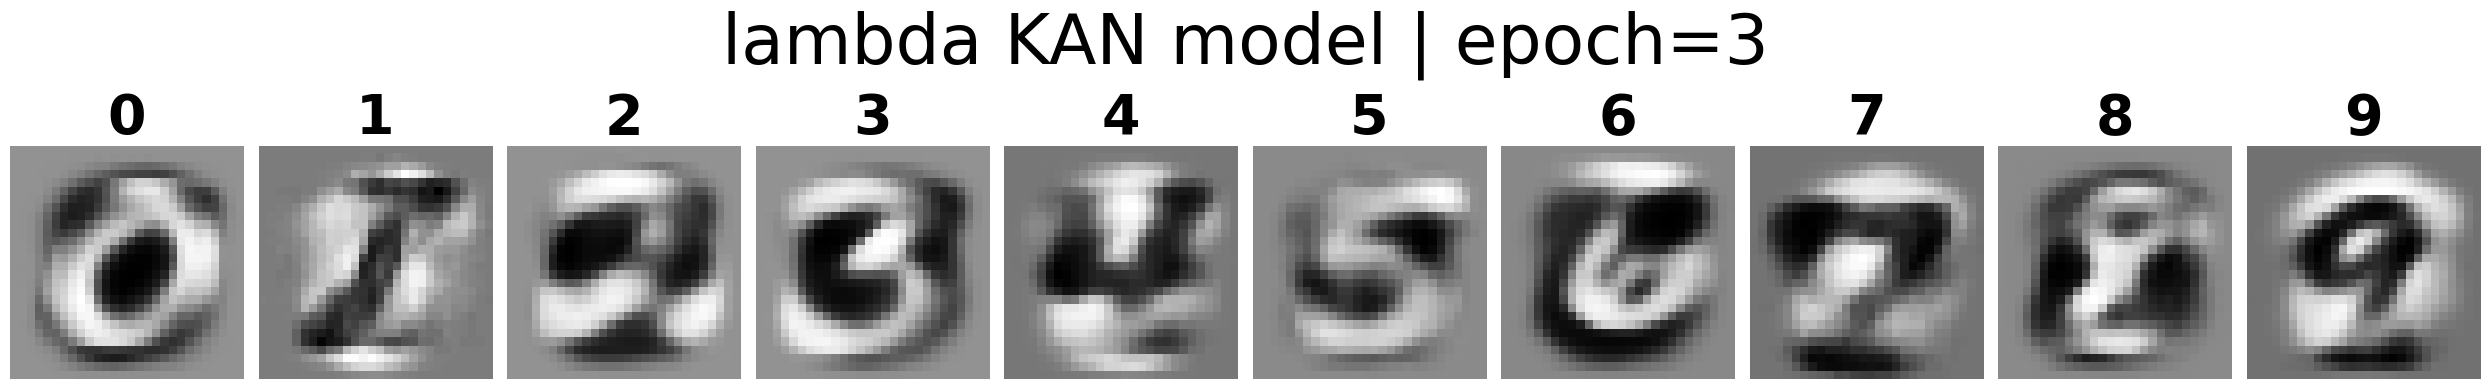

Epoch 3: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.731]Shape with bias: (784, 10)


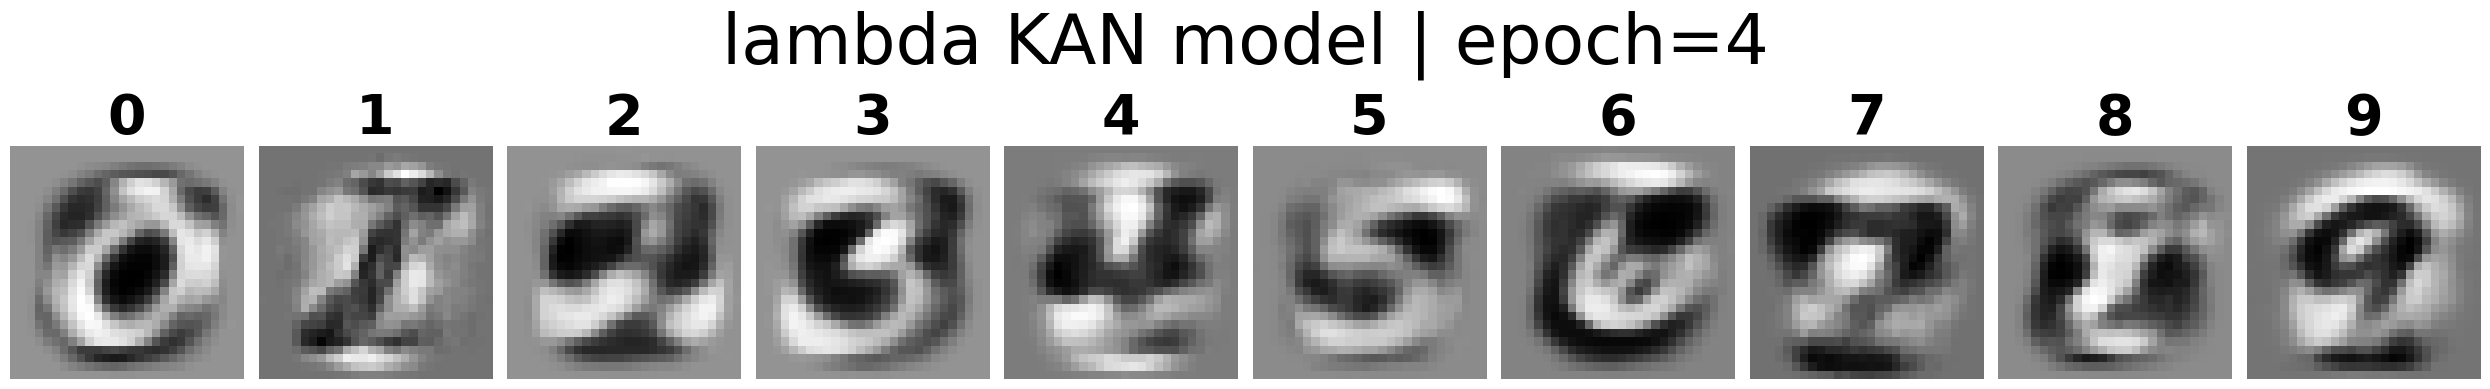

Epoch 0: 100%|██████████| 196/196 [29:40<00:00,  0.11it/s, v_num=0, loss=0.308]


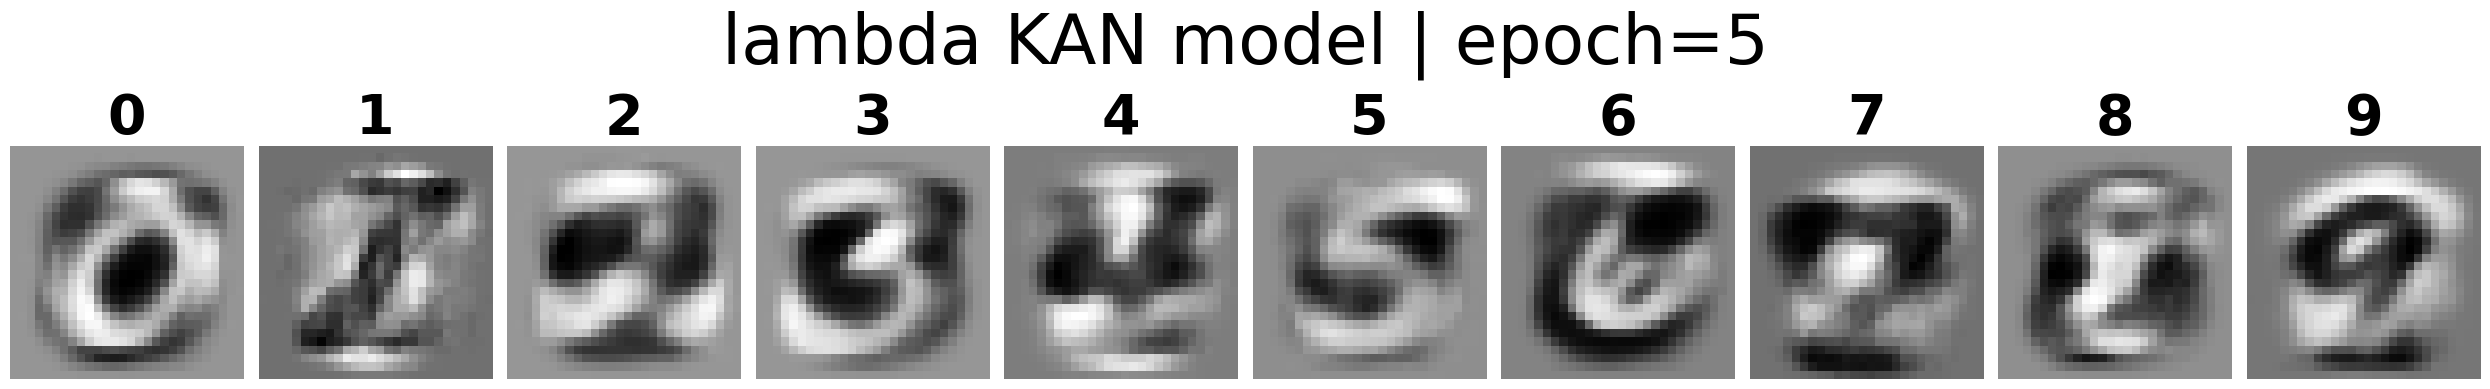

Epoch 5: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s, v_num=0, loss=0.716]Shape with bias: (784, 10)


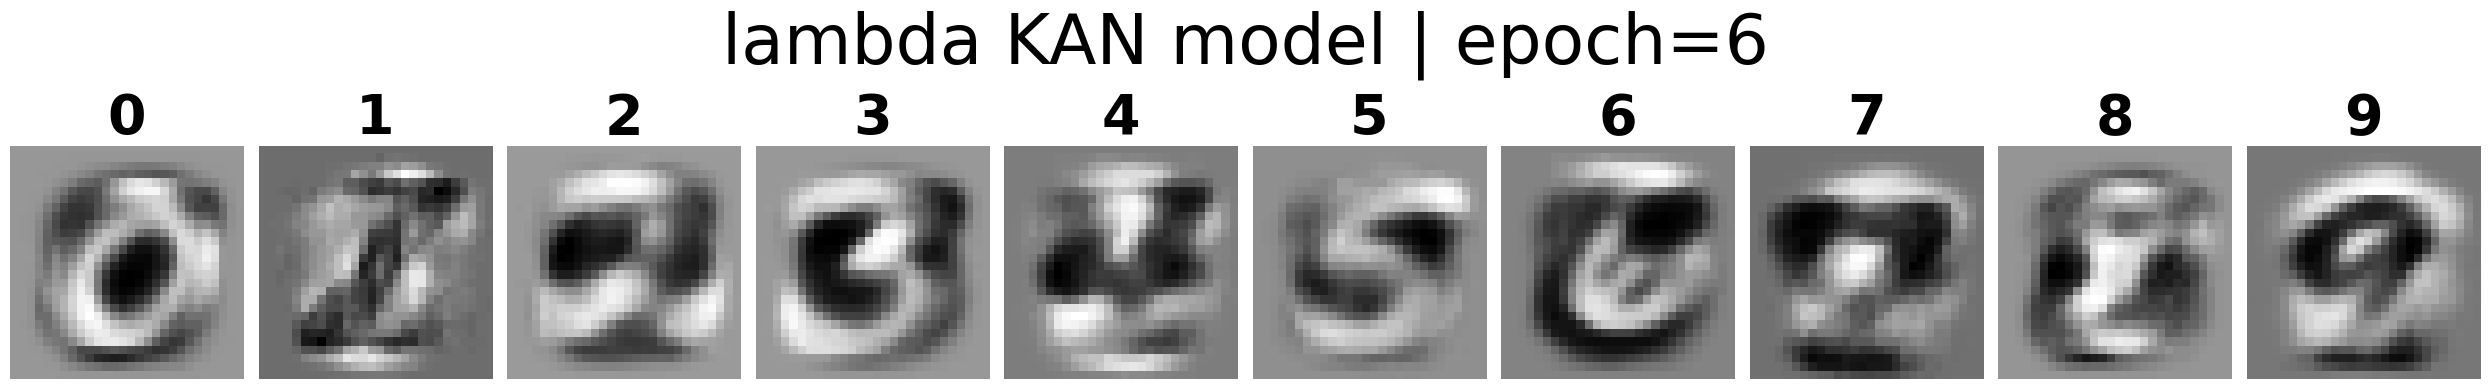

Epoch 6: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.513]Shape with bias: (784, 10)


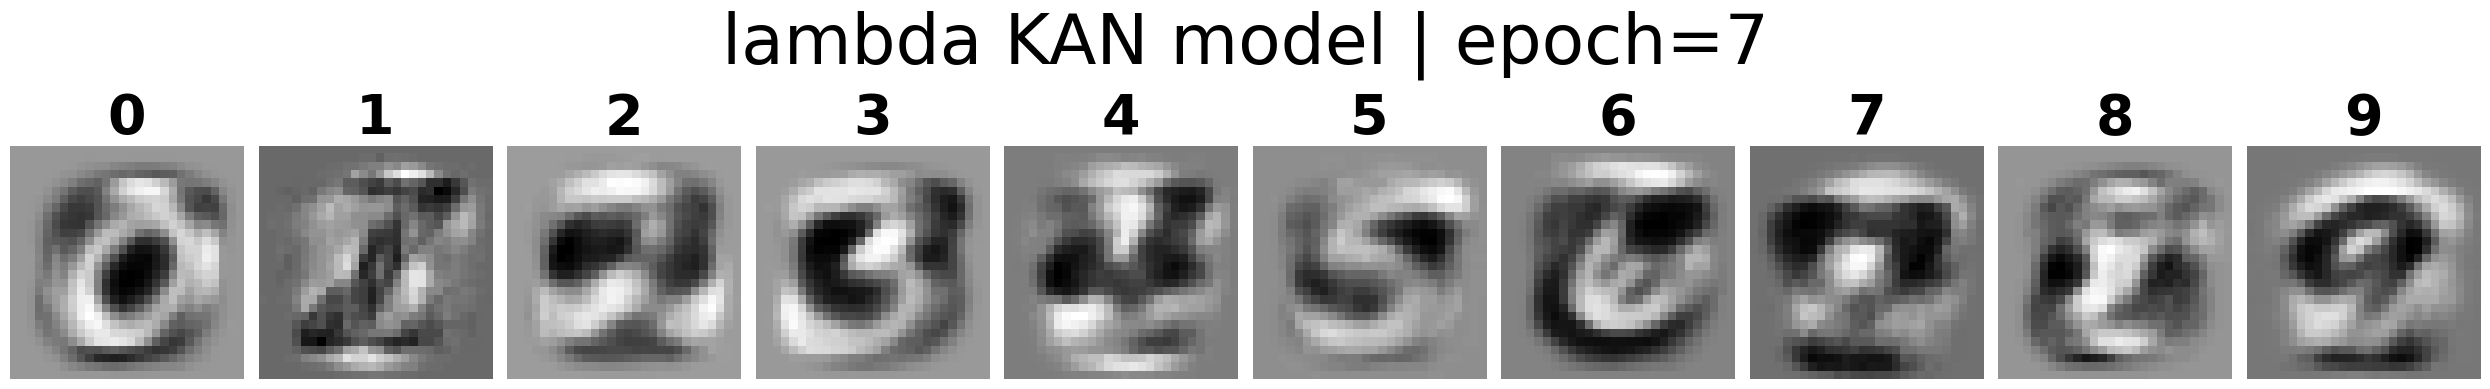

Epoch 7: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.458]Shape with bias: (784, 10)


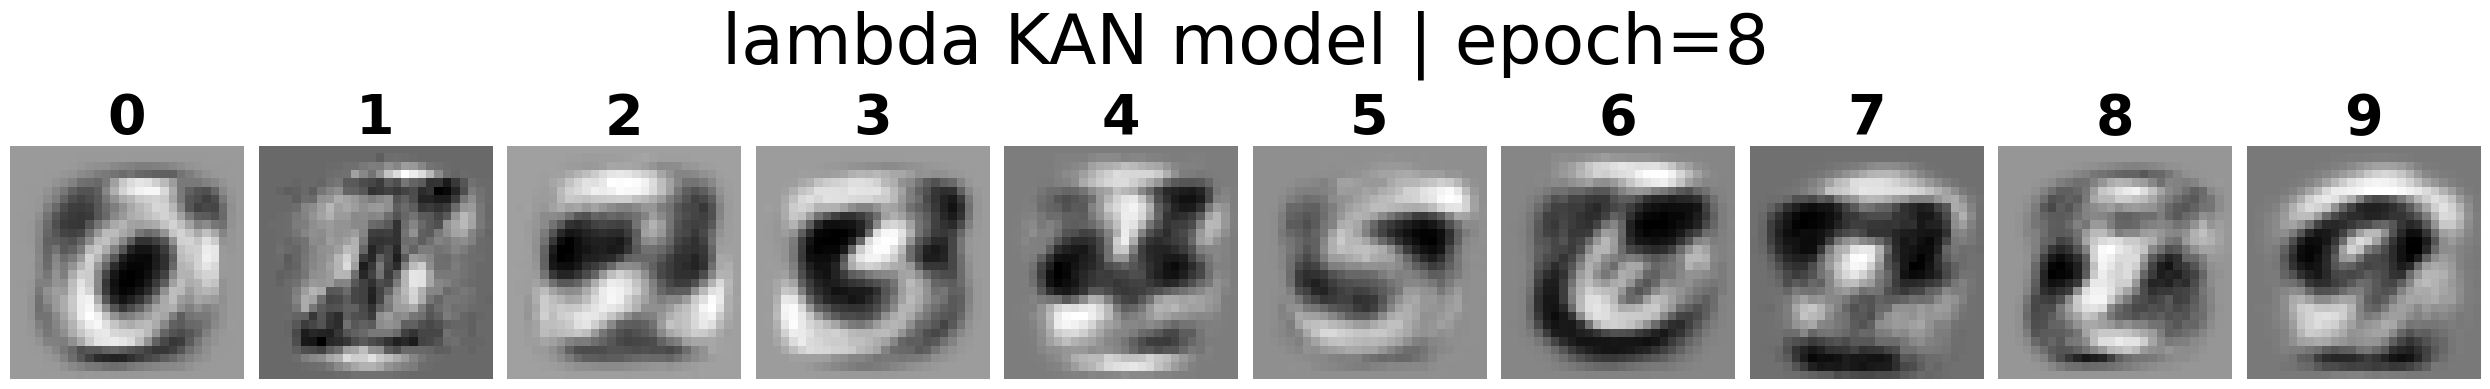

Epoch 8: 100%|██████████| 196/196 [00:25<00:00,  7.81it/s, v_num=0, loss=0.569]Shape with bias: (784, 10)


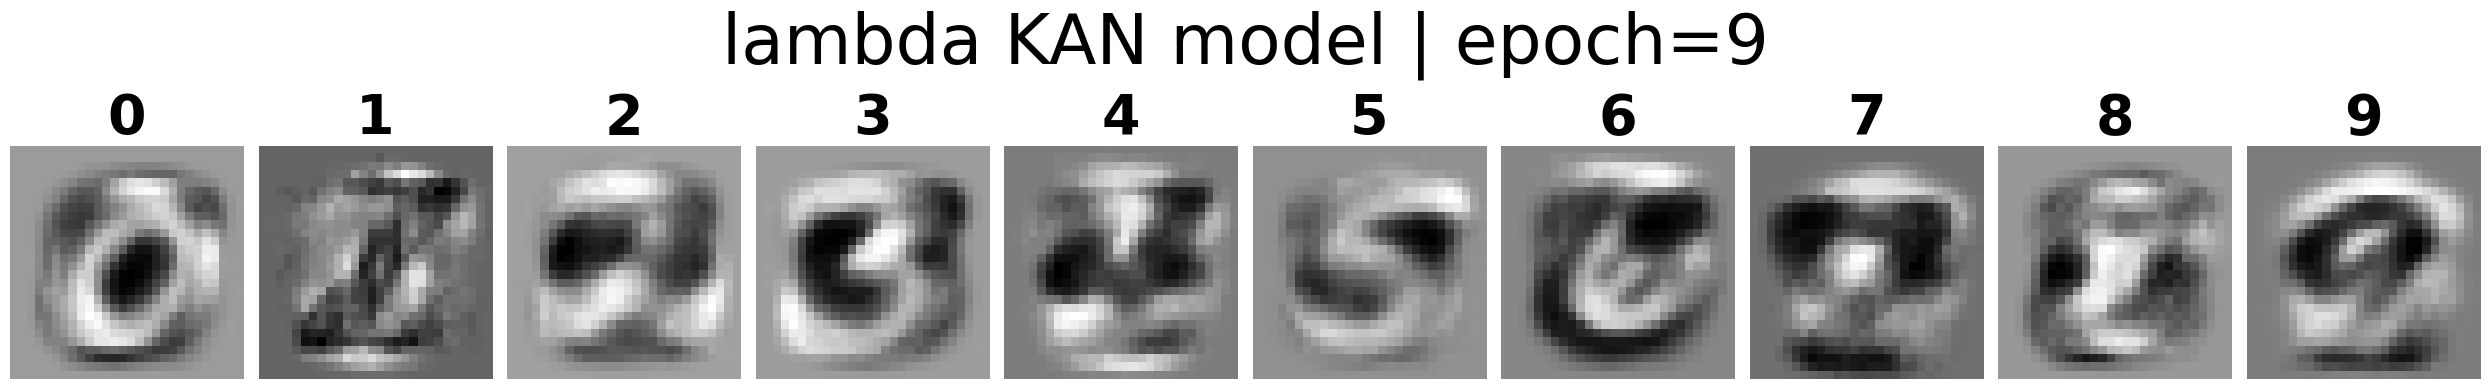

Epoch 9: 100%|██████████| 196/196 [00:25<00:00,  7.81it/s, v_num=0, loss=0.610]Shape with bias: (784, 10)


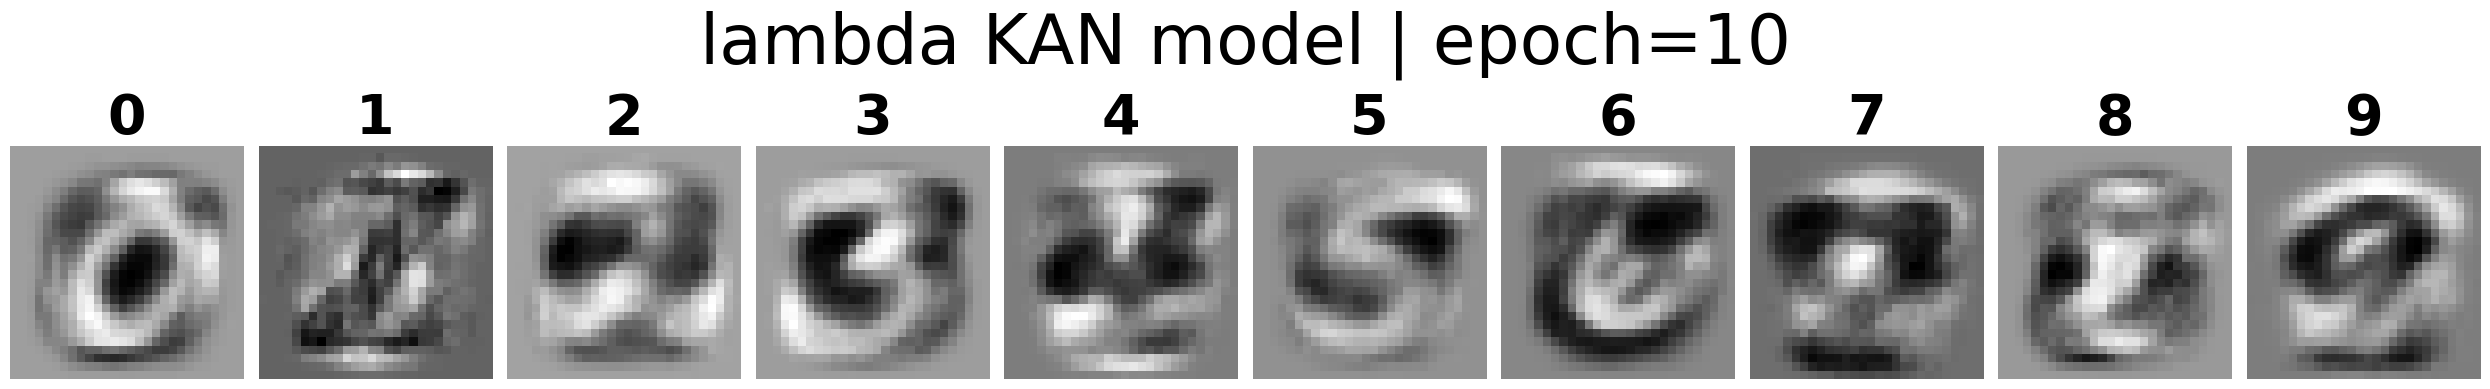

Epoch 10: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.495]Shape with bias: (784, 10)


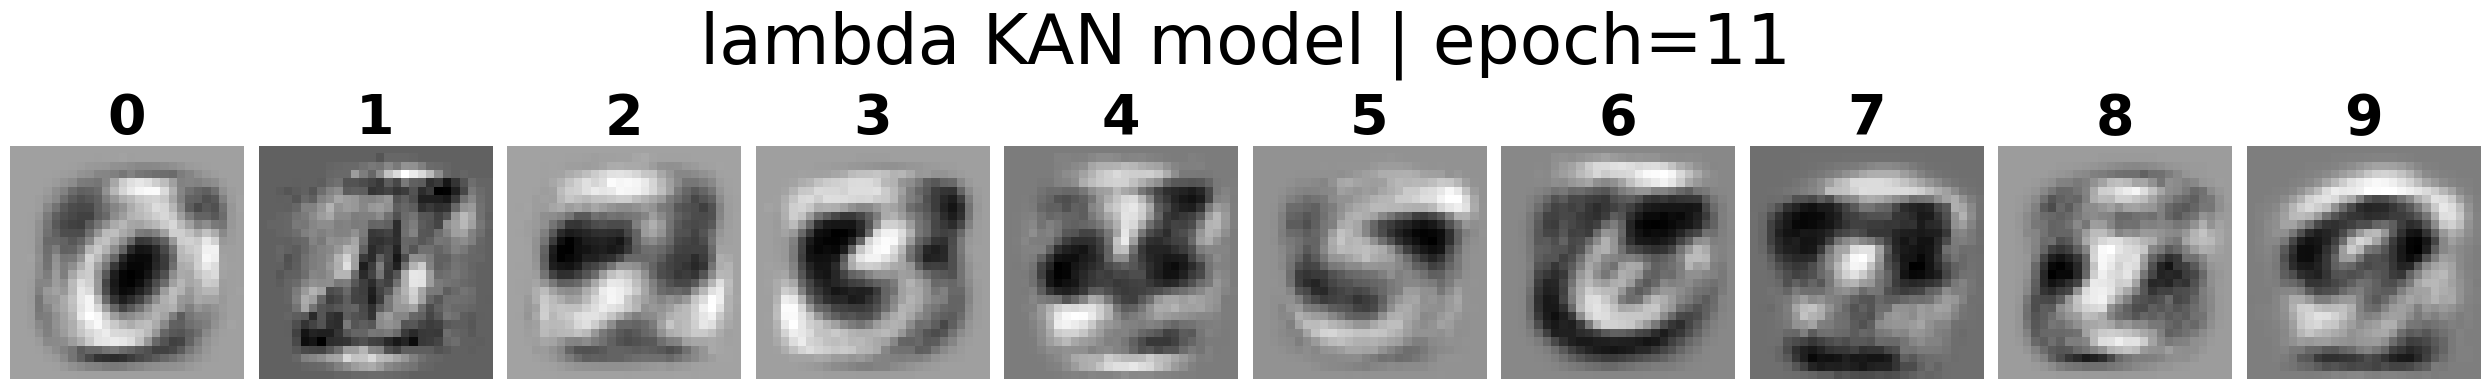

Epoch 11: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.414]Shape with bias: (784, 10)


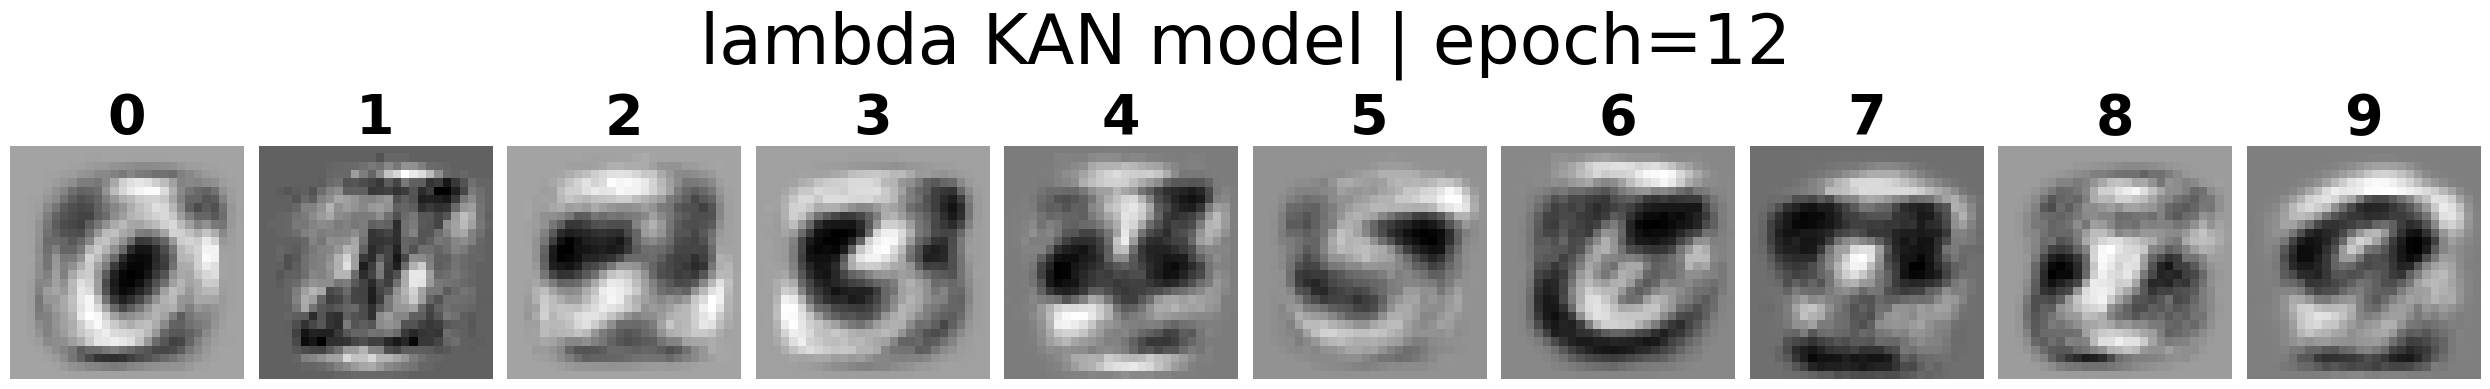

Epoch 12: 100%|██████████| 196/196 [00:25<00:00,  7.81it/s, v_num=0, loss=0.350]Shape with bias: (784, 10)


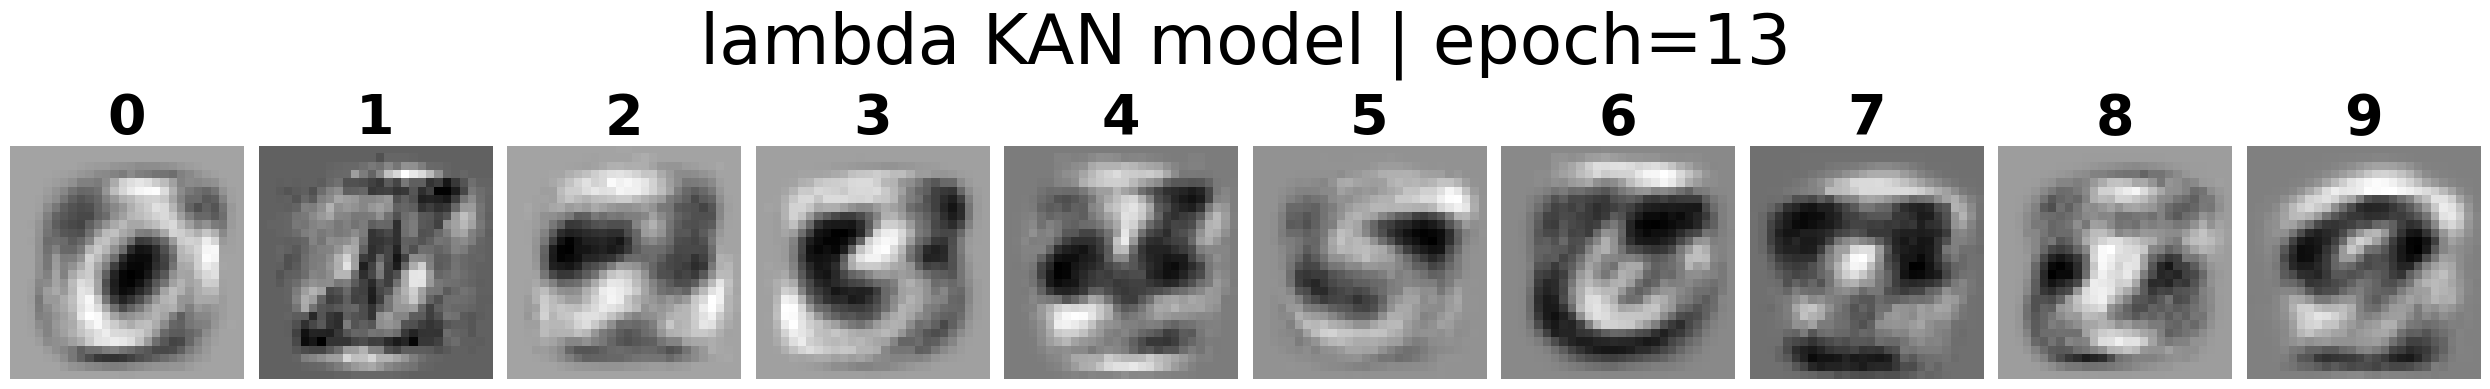

Epoch 13: 100%|██████████| 196/196 [00:25<00:00,  7.82it/s, v_num=0, loss=0.480]Shape with bias: (784, 10)


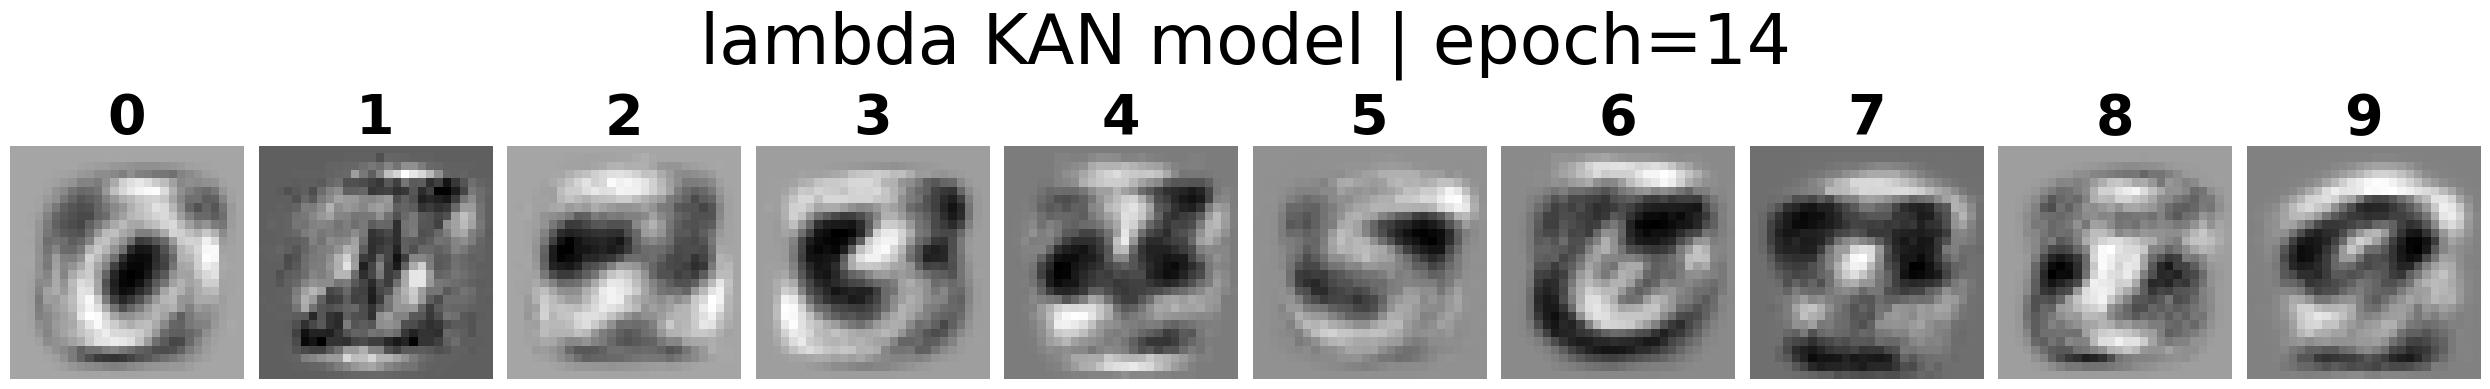

Epoch 14: 100%|██████████| 196/196 [00:25<00:00,  7.81it/s, v_num=0, loss=0.522]Shape with bias: (784, 10)


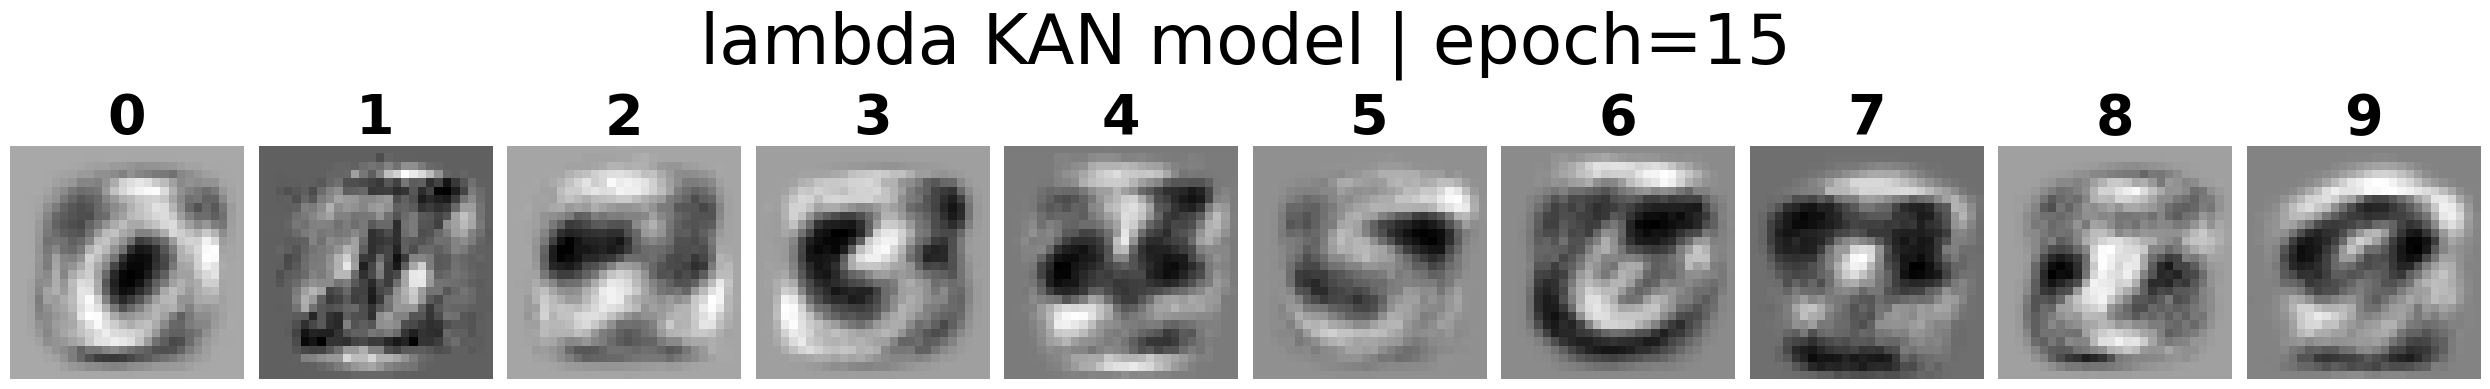

Epoch 15: 100%|██████████| 196/196 [00:25<00:00,  7.80it/s, v_num=0, loss=0.397]Shape with bias: (784, 10)


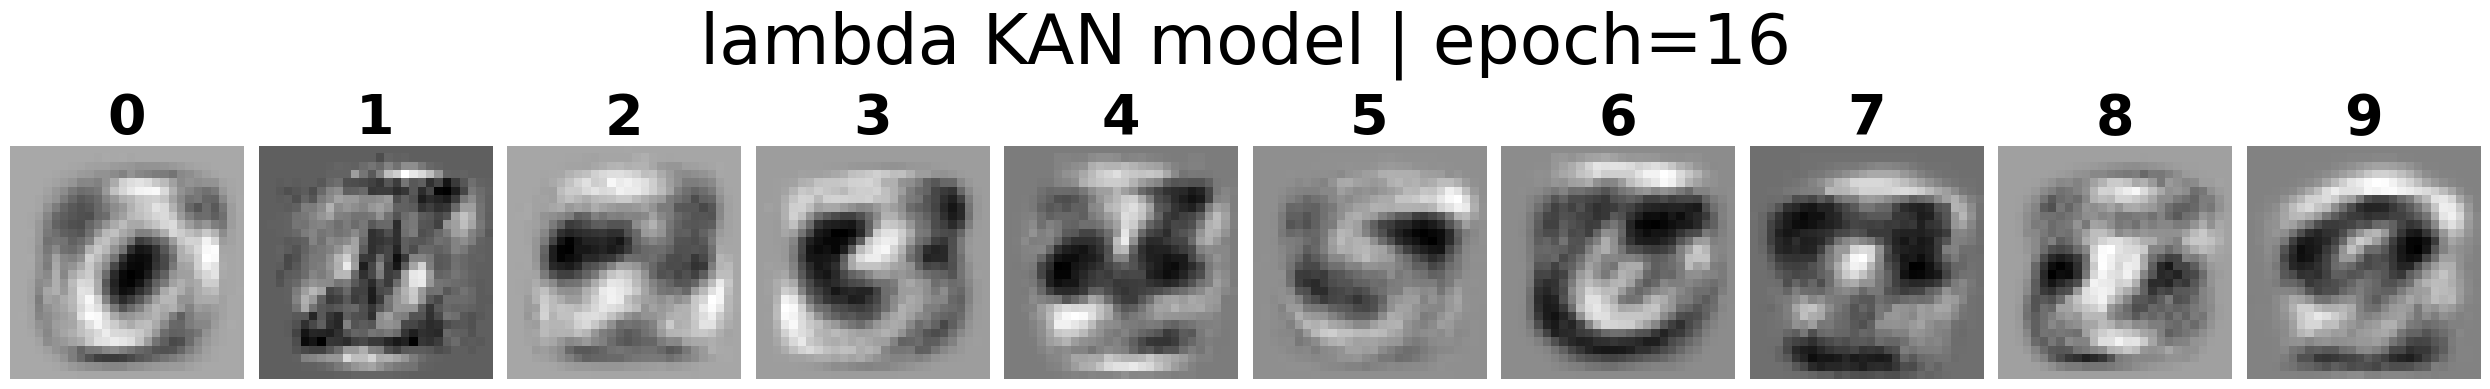

Epoch 16: 100%|██████████| 196/196 [00:25<00:00,  7.79it/s, v_num=0, loss=0.340]Shape with bias: (784, 10)


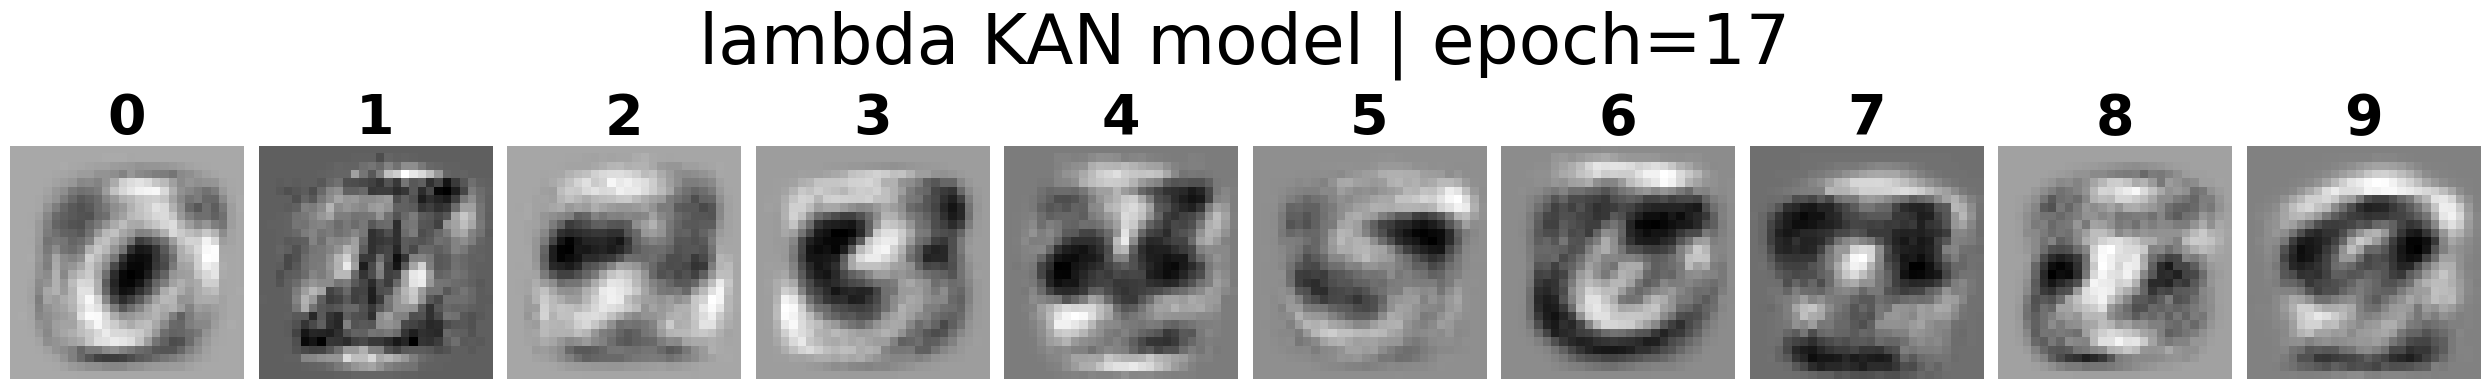

Epoch 17: 100%|██████████| 196/196 [00:25<00:00,  7.79it/s, v_num=0, loss=0.545]Shape with bias: (784, 10)


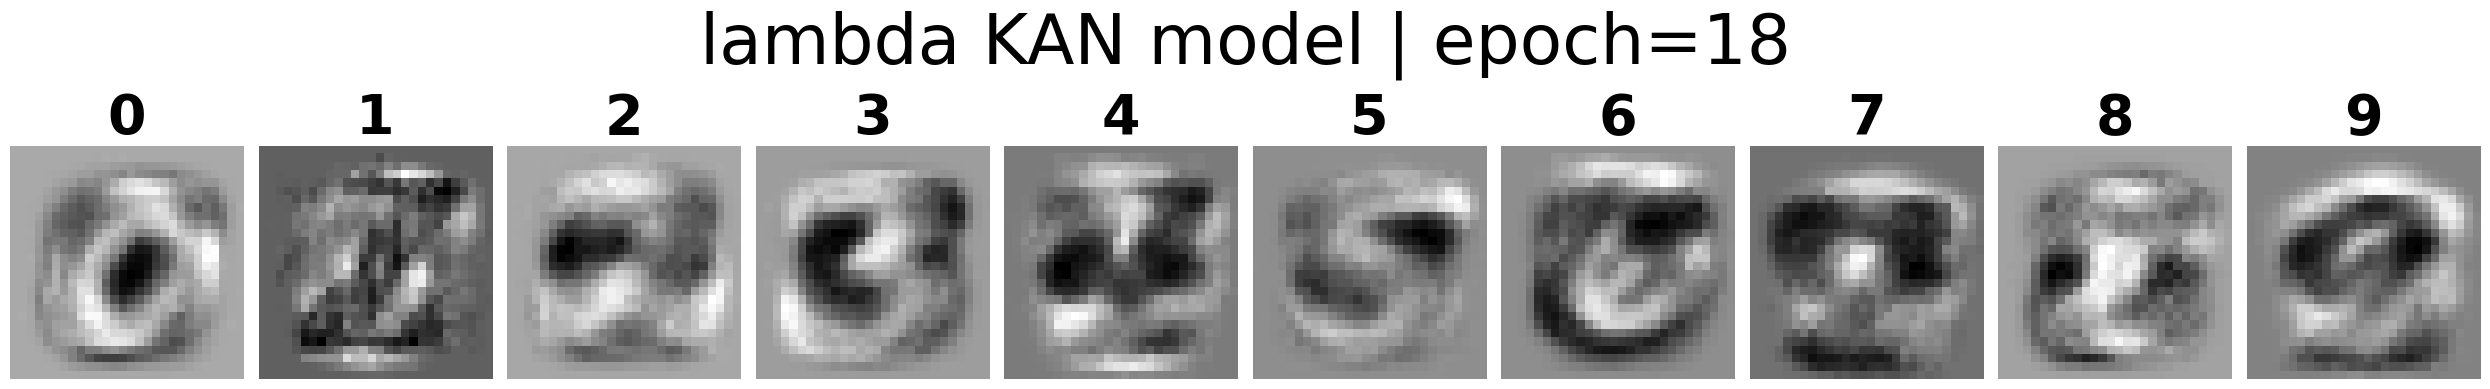

Epoch 18: 100%|██████████| 196/196 [00:25<00:00,  7.78it/s, v_num=0, loss=0.267]Shape with bias: (784, 10)


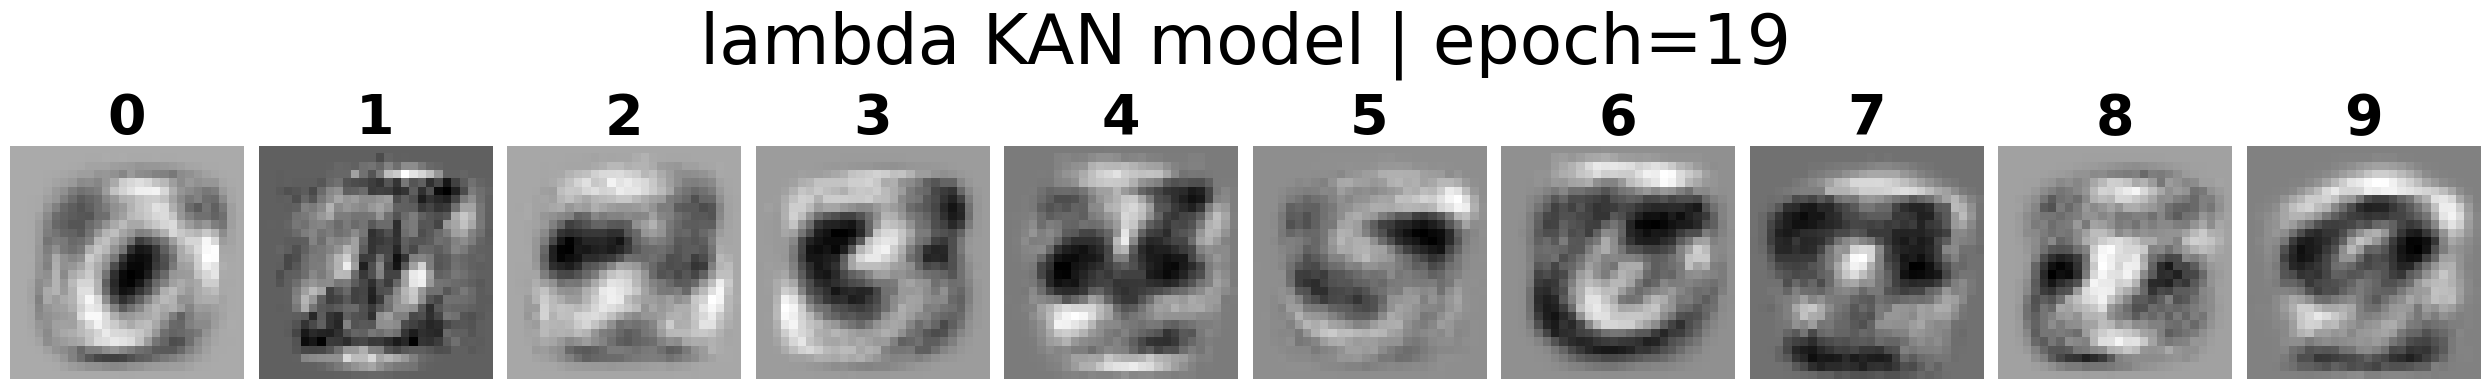

Epoch 19: 100%|██████████| 196/196 [00:25<00:00,  7.77it/s, v_num=0, loss=0.303]Shape with bias: (784, 10)


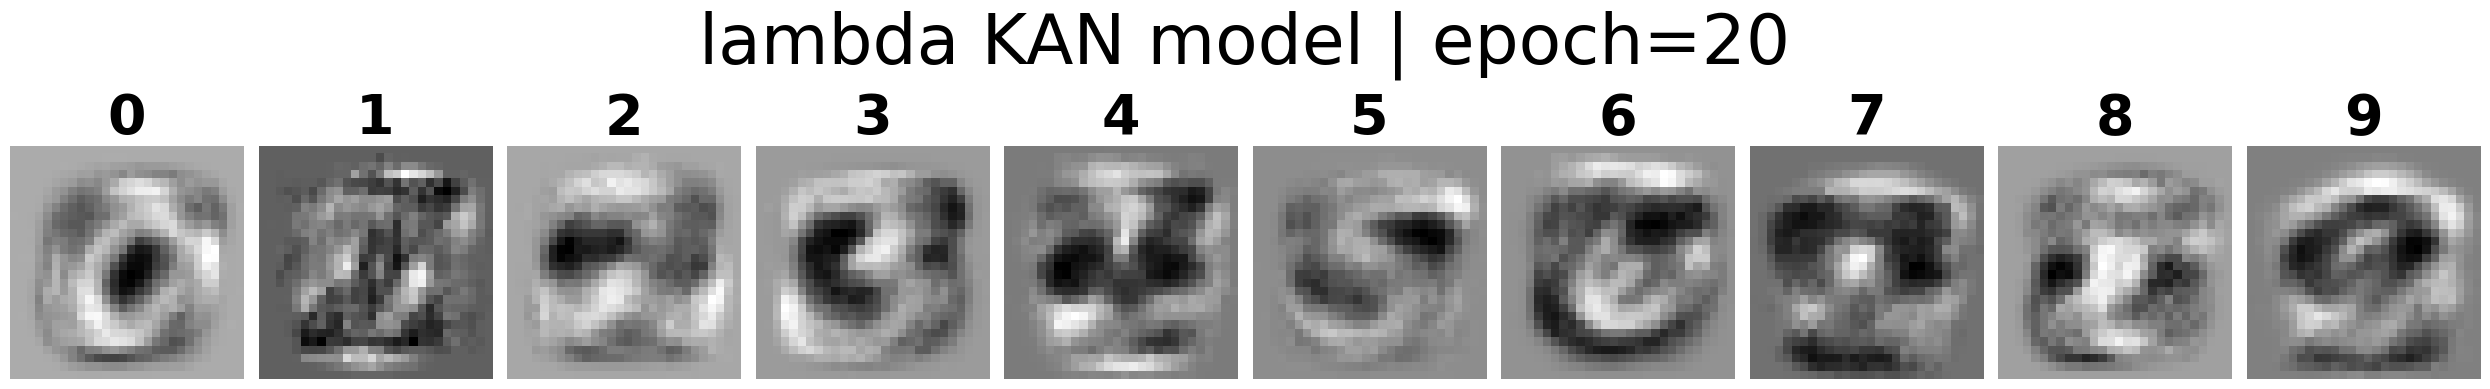

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 196/196 [00:25<00:00,  7.60it/s, v_num=0, loss=0.303]


In [10]:
class LModel_save_pic(LModel):
    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()
        
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        
        directory = self.logger.log_dir + '\\sens_pic'
        if not os.path.exists(directory):
            os.makedirs(directory)
        show_sensitivity(W = self.model.get_W(),
                         title = f'lambda KAN model | epoch={self.current_epoch+1}',
                         save_pic=True, 
                         file_path=directory + f'\\{self.current_epoch}.png')


checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

L.seed_everything(1755)

model = Mnist_lmdSplineKAN() #Mnist_lmdSplineKAN() #MnistPrllSplineKAN() #MnistSplineKAN() #MnistSplineKAN() #MnistKAN() #MnistMLP() #MnistCNN() #MnistLR()
pl_model = LModel_save_pic(model)
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir=f"./logs/{type(model).__name__}/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

In [11]:
# Load the best checkpoint automatically (lightning tracks this for you)
trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)

Restoring states from the checkpoint path at ./logs/Mnist_lmdSplineKAN/lightning_logs\version_0\checkpoints\model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_lmdSplineKAN/lightning_logs\version_0\checkpoints\model.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:02<00:00, 13.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.8921772241592407     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.8921772241592407}]

#### Mnist_tlmdSplineKAN

Seed set to 1755
c:\Users\Student\VSprojects_Gavr\lambda_KAN\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | model         | Mnist_tlmdSplineKAN | 1.5 M  | 

Epoch 0: 100%|██████████| 196/196 [00:29<00:00,  6.76it/s, v_num=0, loss=0.947]Shape with bias: (784, 10)


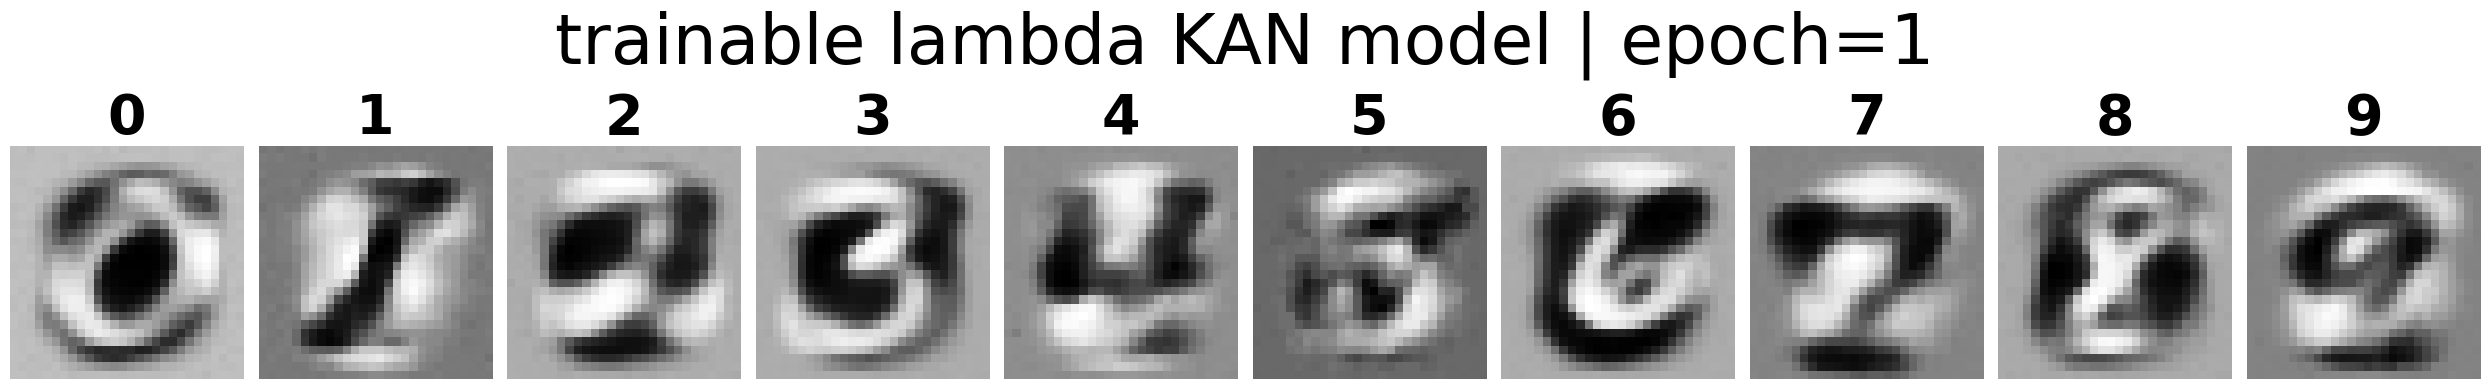

Epoch 1: 100%|██████████| 196/196 [00:25<00:00,  7.55it/s, v_num=0, loss=0.934]Shape with bias: (784, 10)


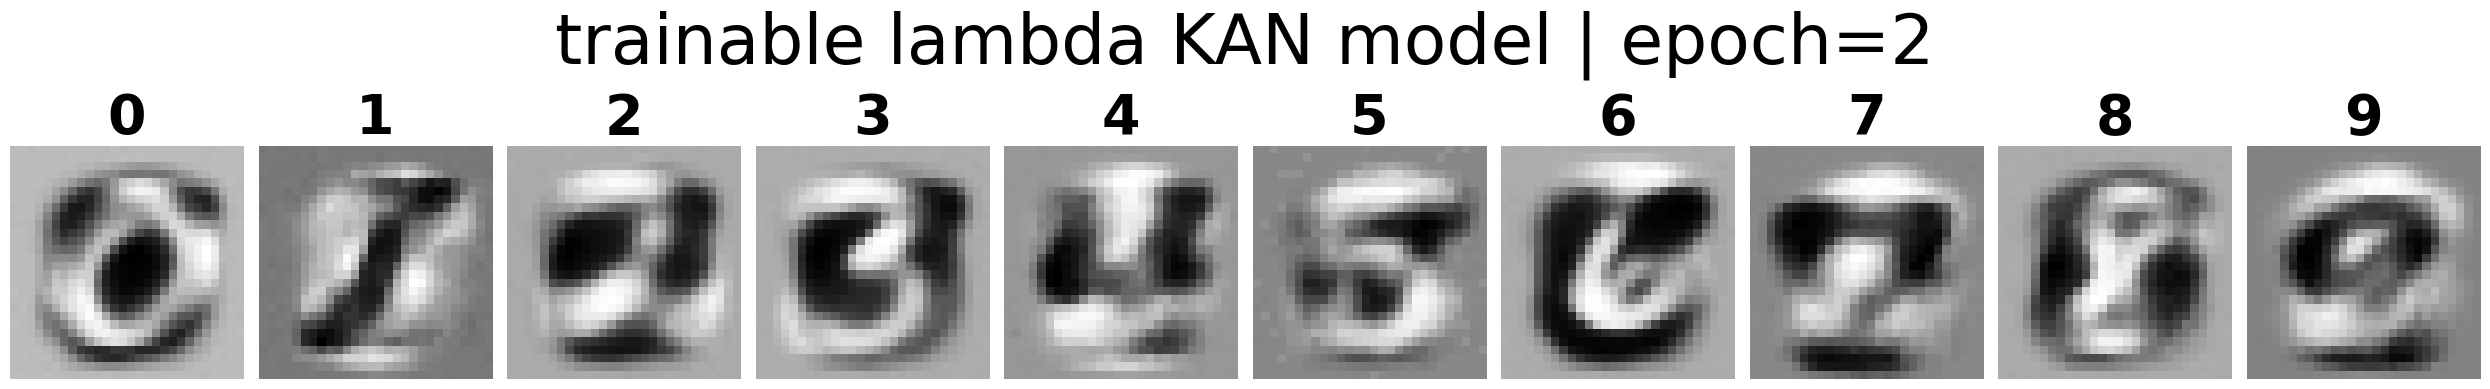

Epoch 2: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s, v_num=0, loss=0.277]Shape with bias: (784, 10)


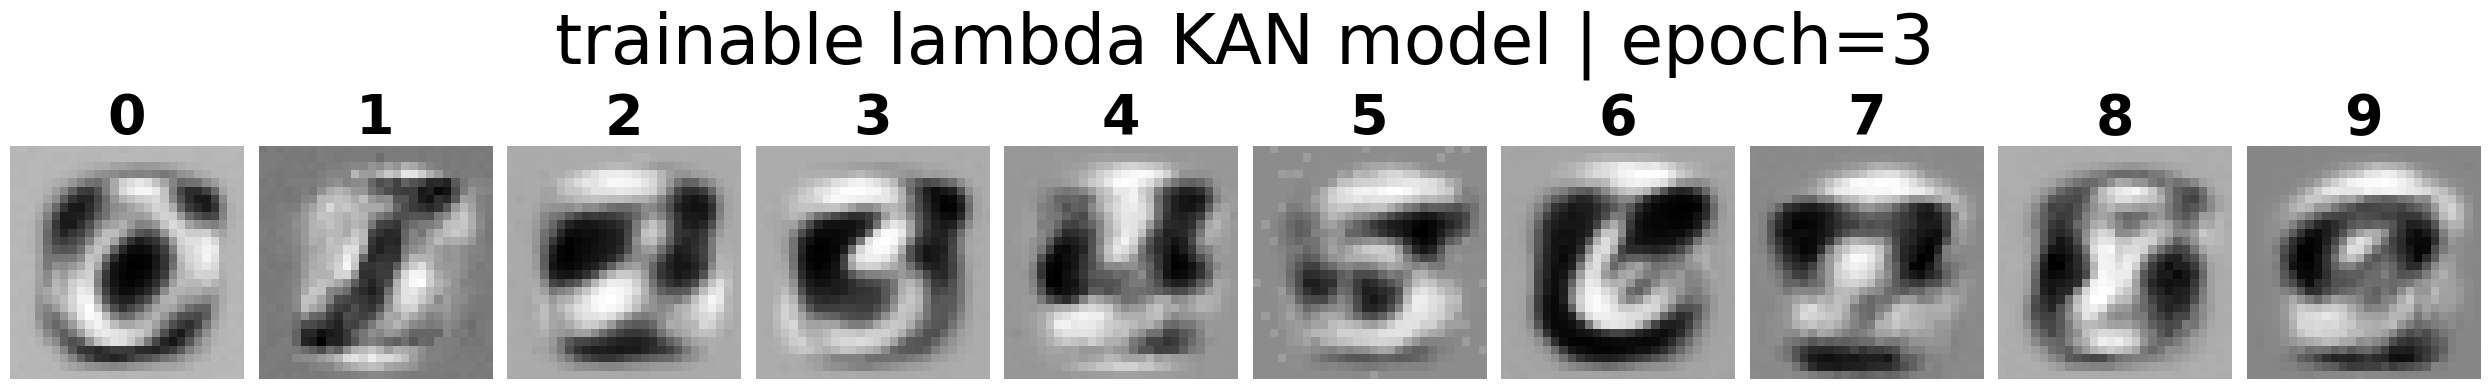

Epoch 3: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s, v_num=0, loss=0.357]Shape with bias: (784, 10)


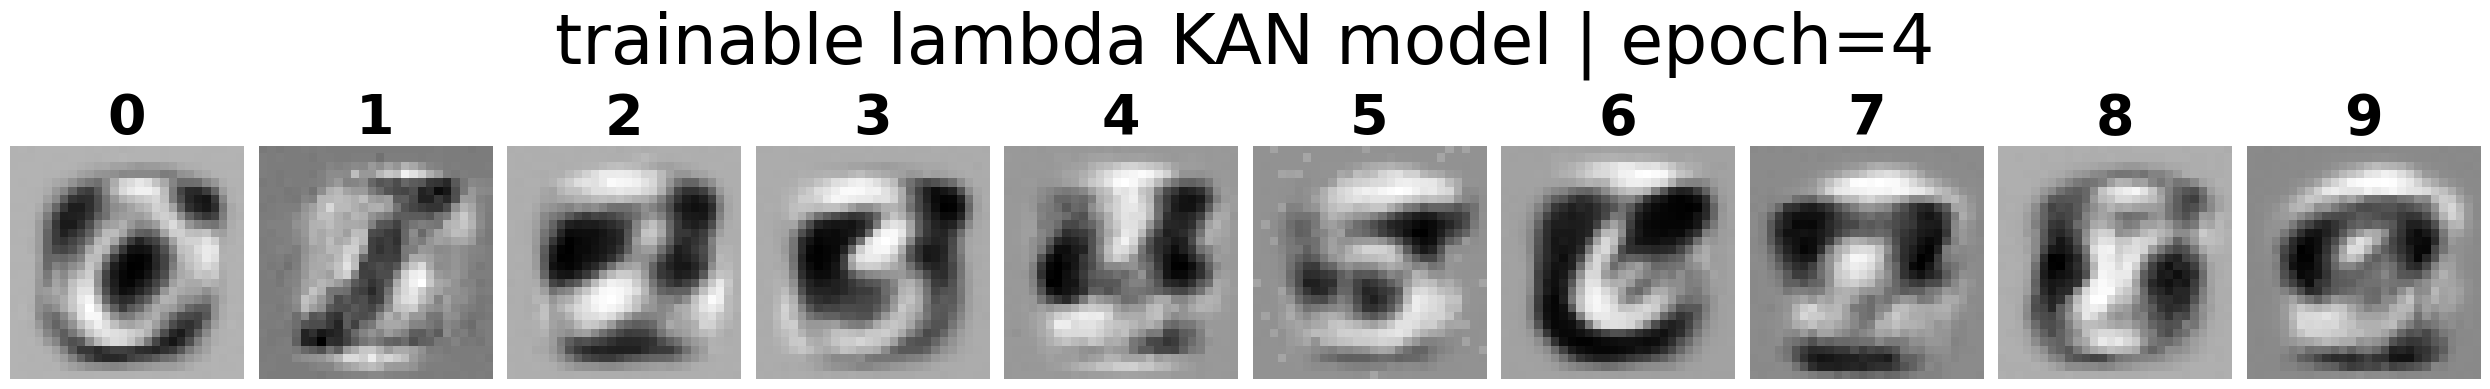

Epoch 4: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s, v_num=0, loss=0.471]Shape with bias: (784, 10)


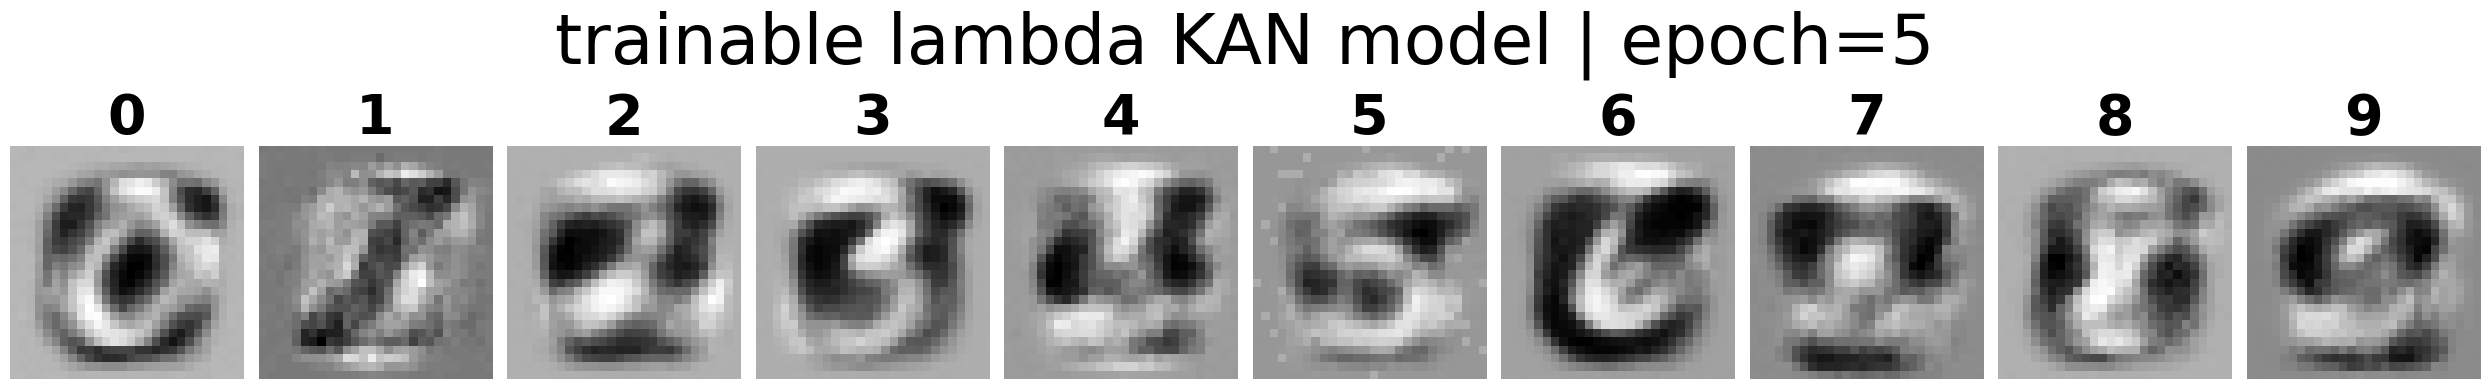

Epoch 5: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s, v_num=0, loss=0.360]Shape with bias: (784, 10)


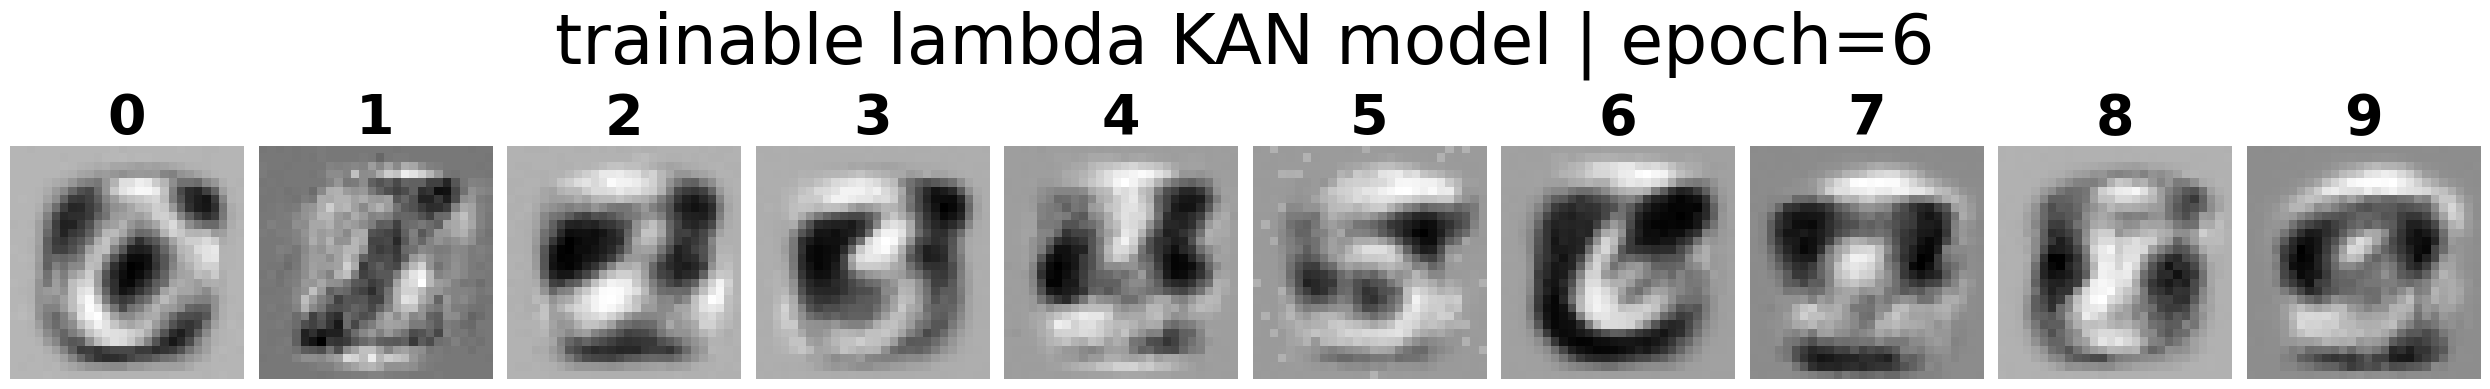

Epoch 6: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s, v_num=0, loss=0.384] Shape with bias: (784, 10)


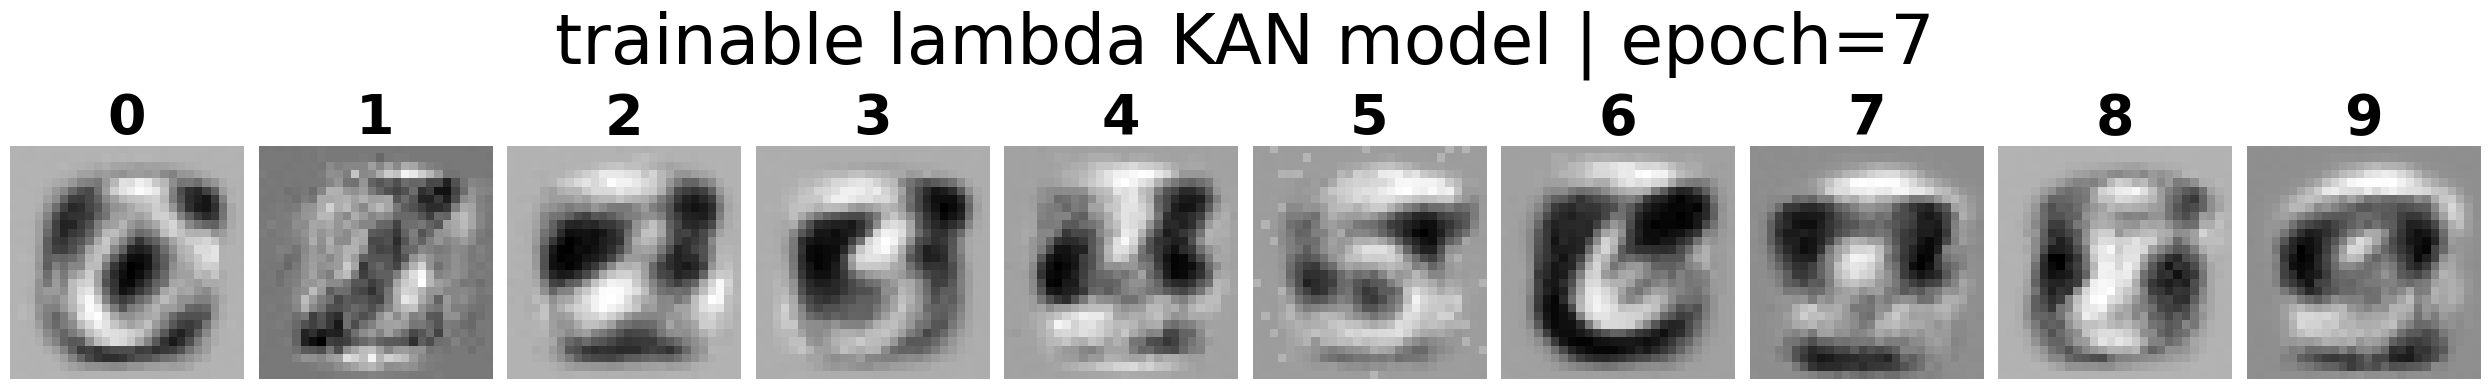

Epoch 7: 100%|██████████| 196/196 [00:26<00:00,  7.54it/s, v_num=0, loss=0.254]Shape with bias: (784, 10)


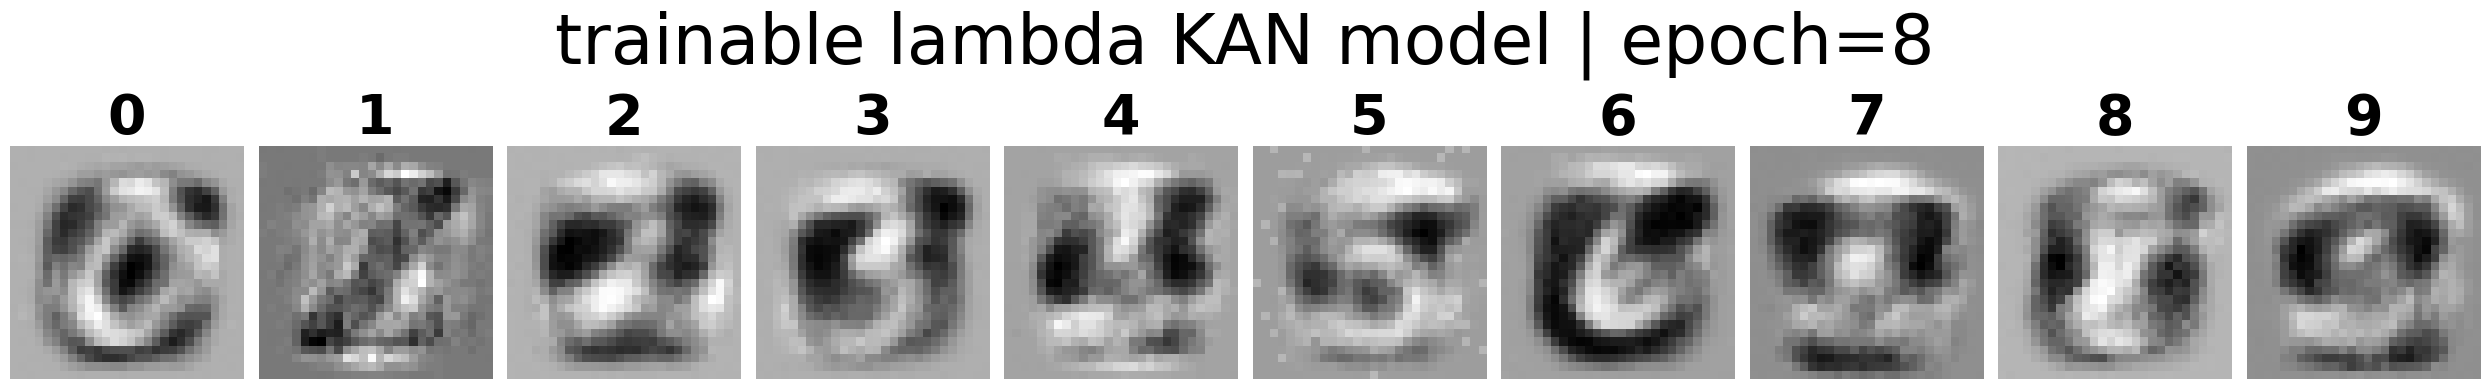

Epoch 8: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s, v_num=0, loss=0.223]Shape with bias: (784, 10)


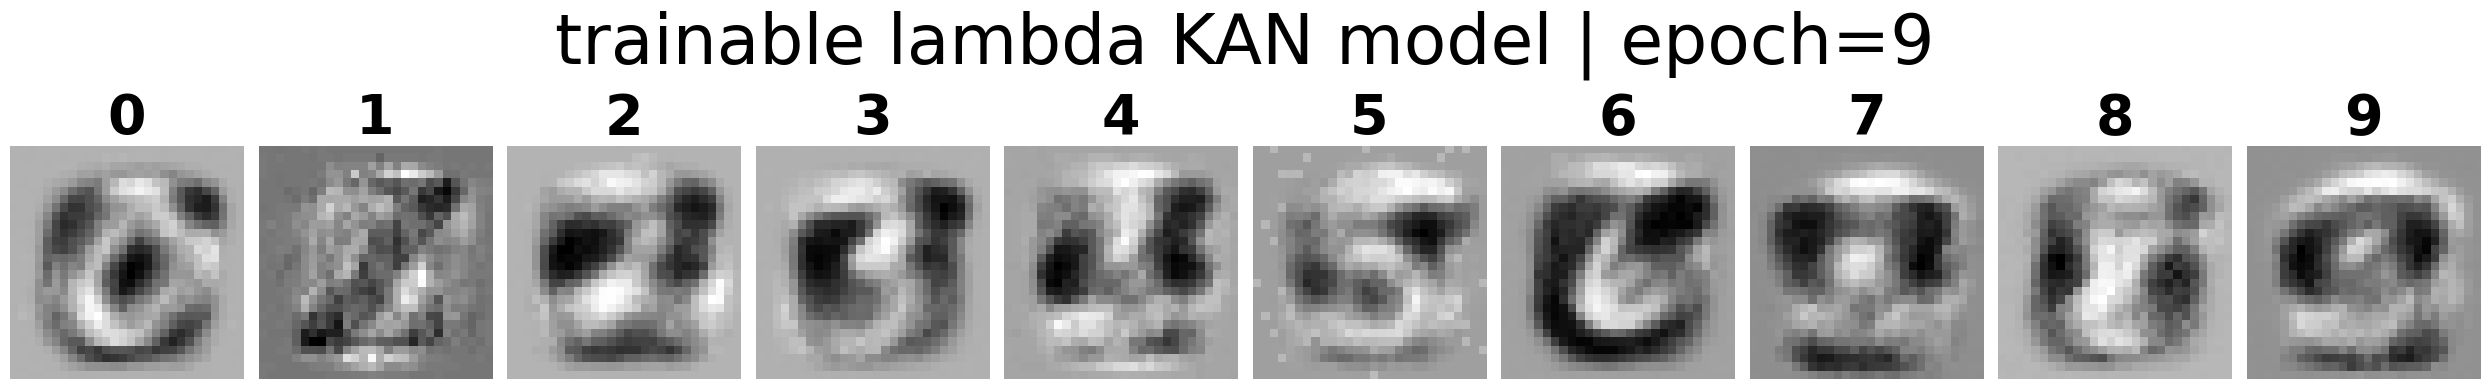

Epoch 9: 100%|██████████| 196/196 [00:25<00:00,  7.54it/s, v_num=0, loss=0.137] Shape with bias: (784, 10)


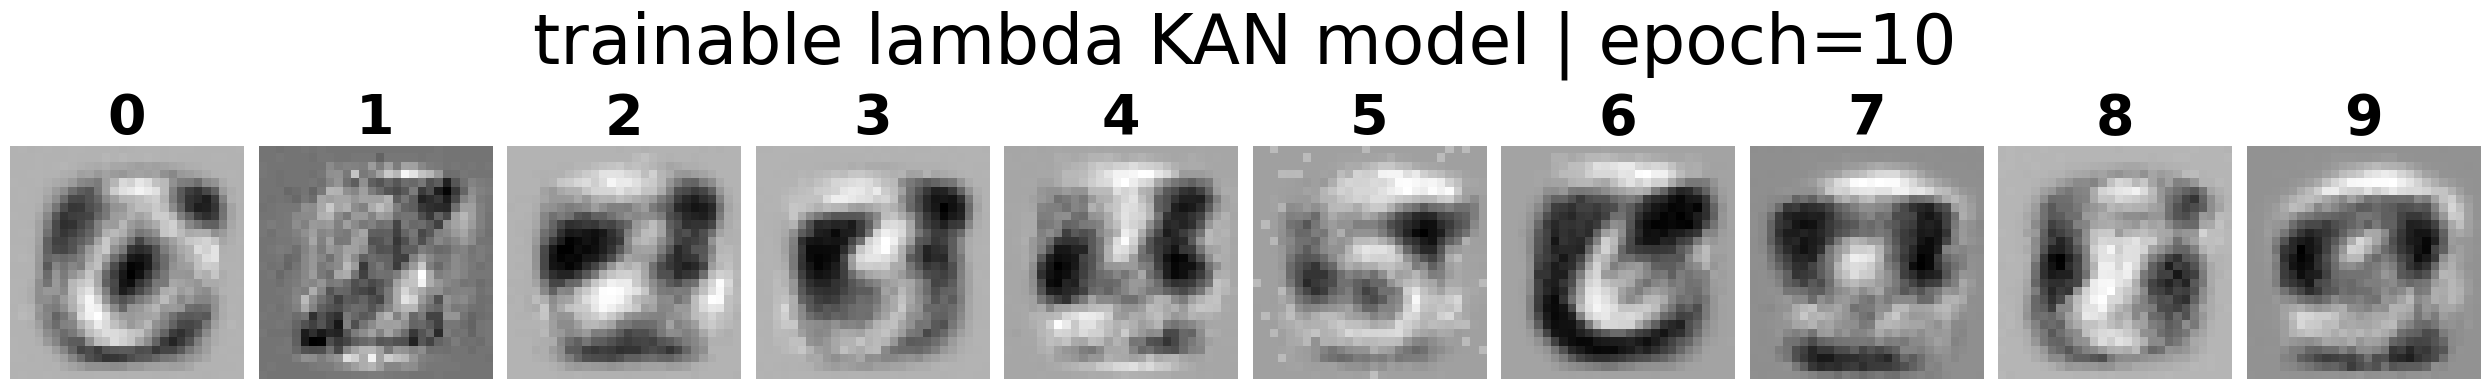

Epoch 10: 100%|██████████| 196/196 [00:26<00:00,  7.54it/s, v_num=0, loss=0.161] Shape with bias: (784, 10)


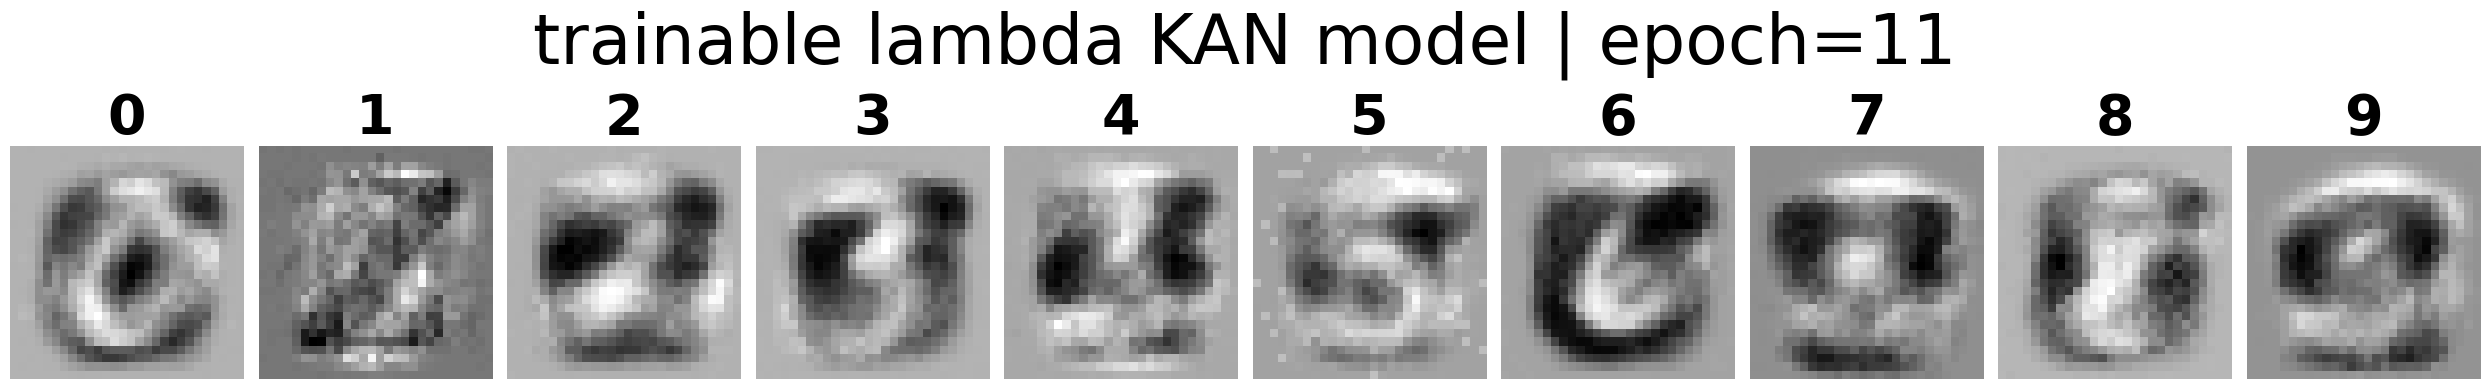

Epoch 11: 100%|██████████| 196/196 [00:26<00:00,  7.54it/s, v_num=0, loss=0.208] Shape with bias: (784, 10)


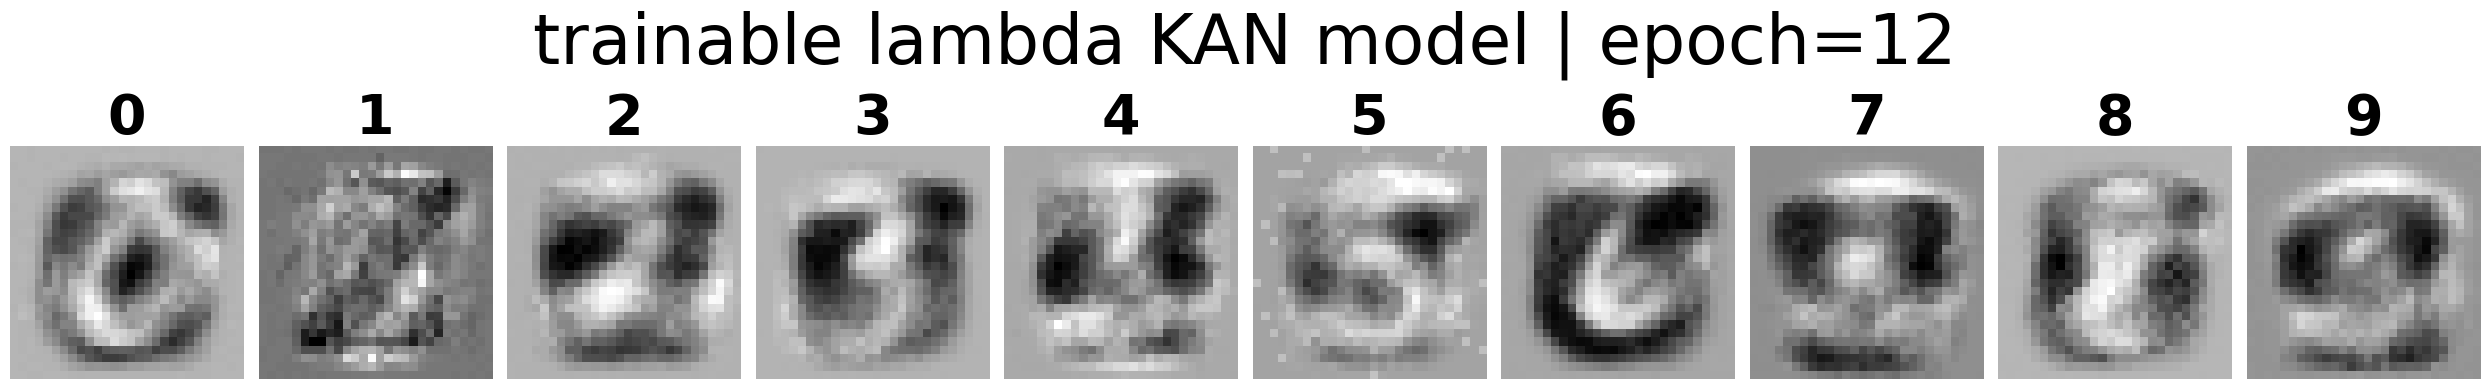

Epoch 12: 100%|██████████| 196/196 [00:26<00:00,  7.54it/s, v_num=0, loss=0.149] Shape with bias: (784, 10)


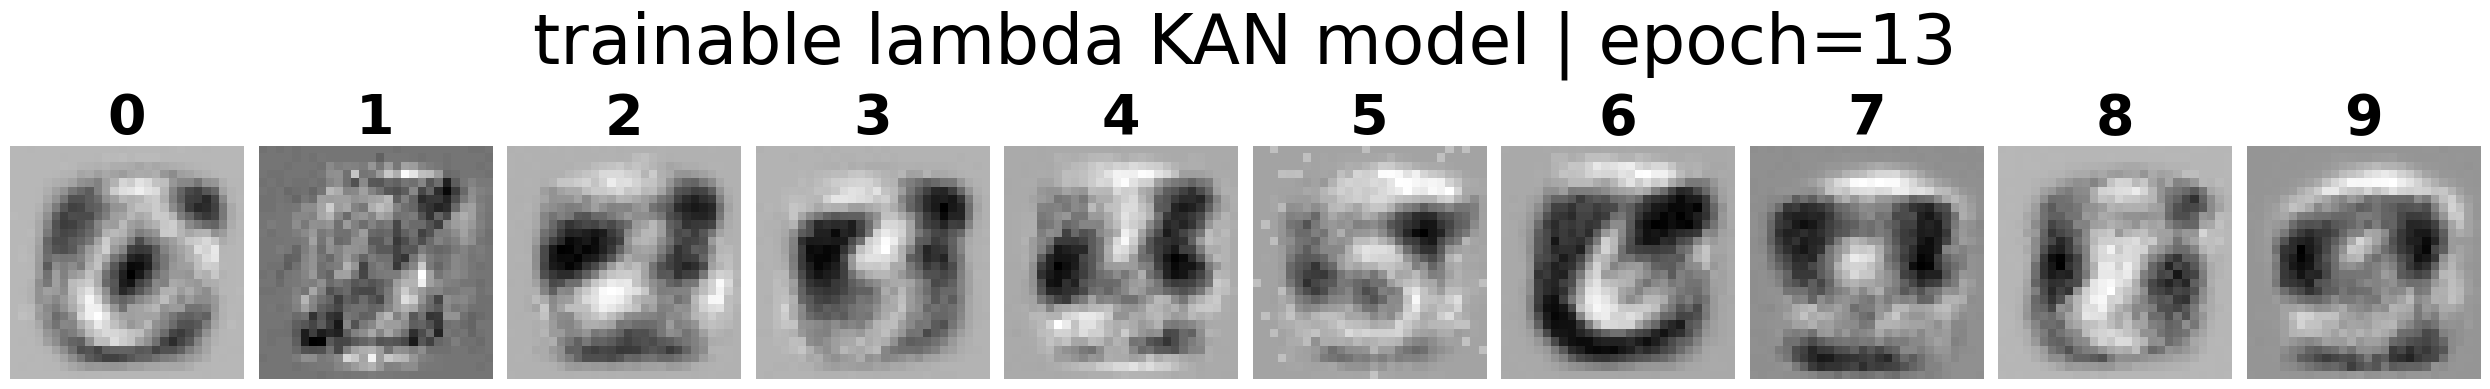

Epoch 13: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s, v_num=0, loss=0.111] Shape with bias: (784, 10)


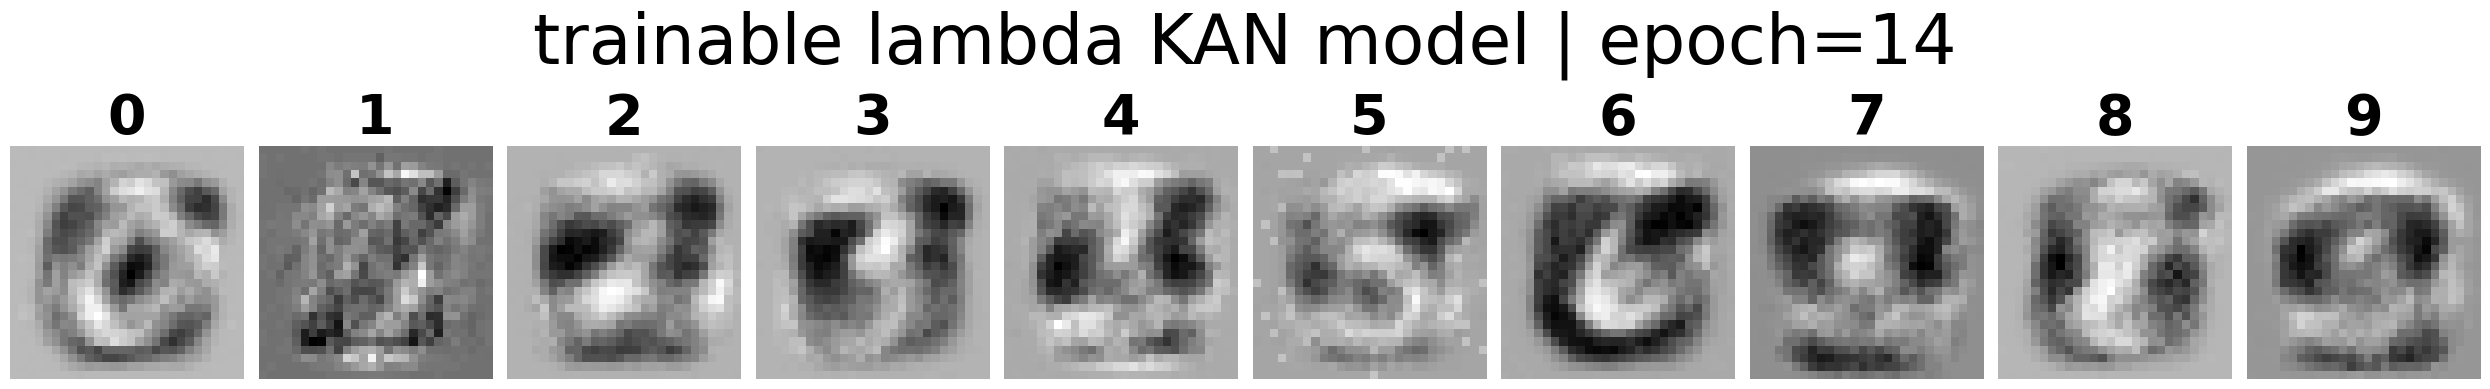

Epoch 14: 100%|██████████| 196/196 [00:26<00:00,  7.52it/s, v_num=0, loss=0.171] Shape with bias: (784, 10)


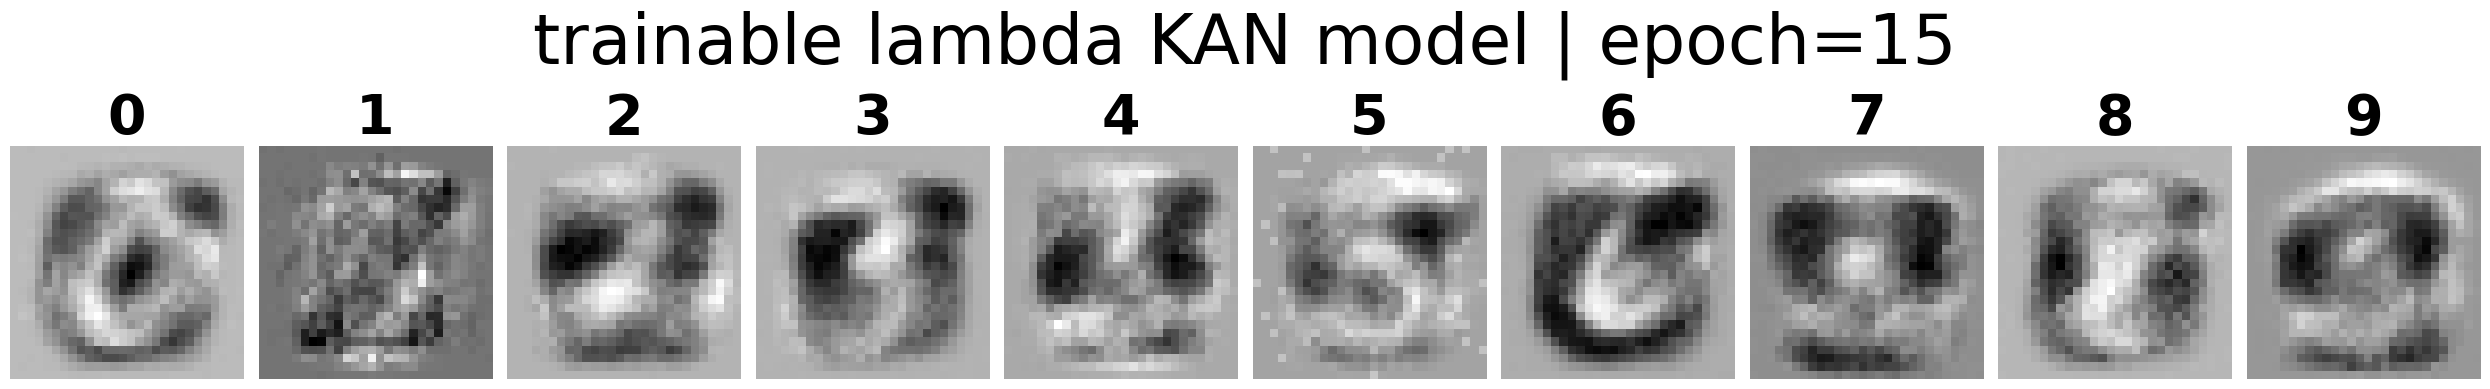

Epoch 15: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s, v_num=0, loss=0.0931]Shape with bias: (784, 10)


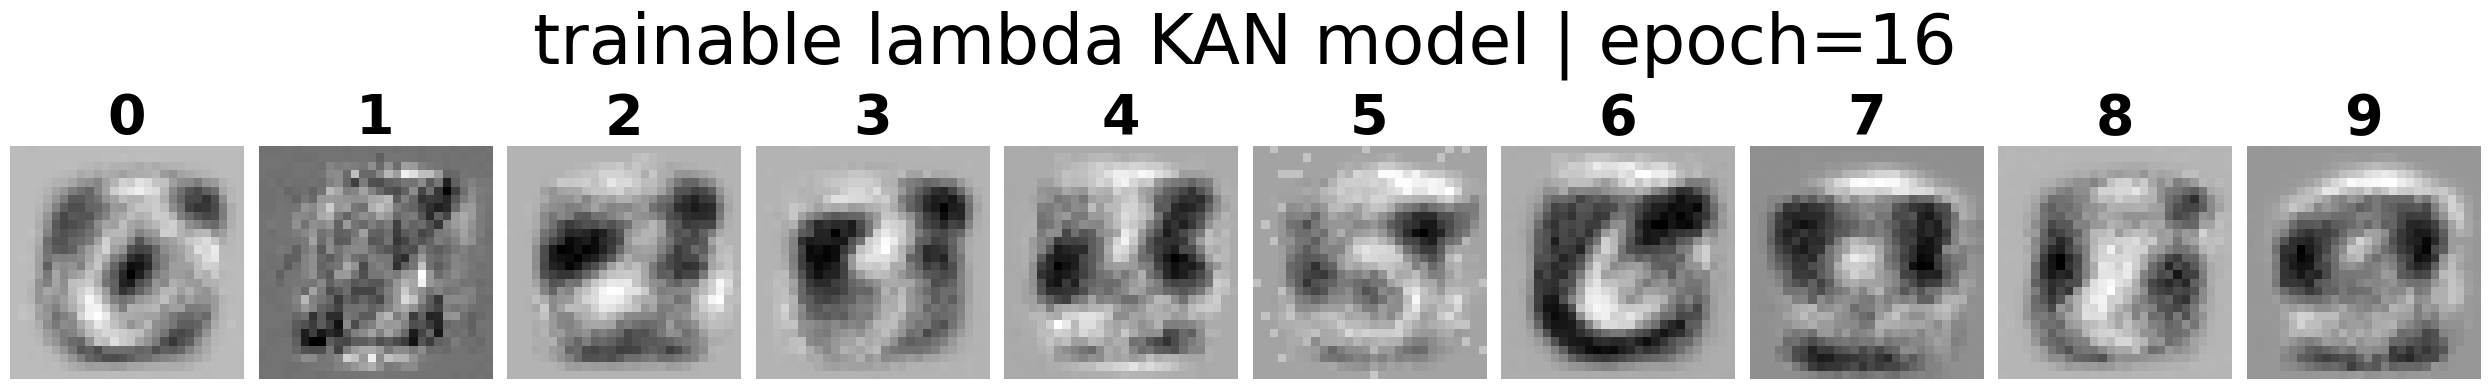

Epoch 16: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s, v_num=0, loss=0.102] Shape with bias: (784, 10)


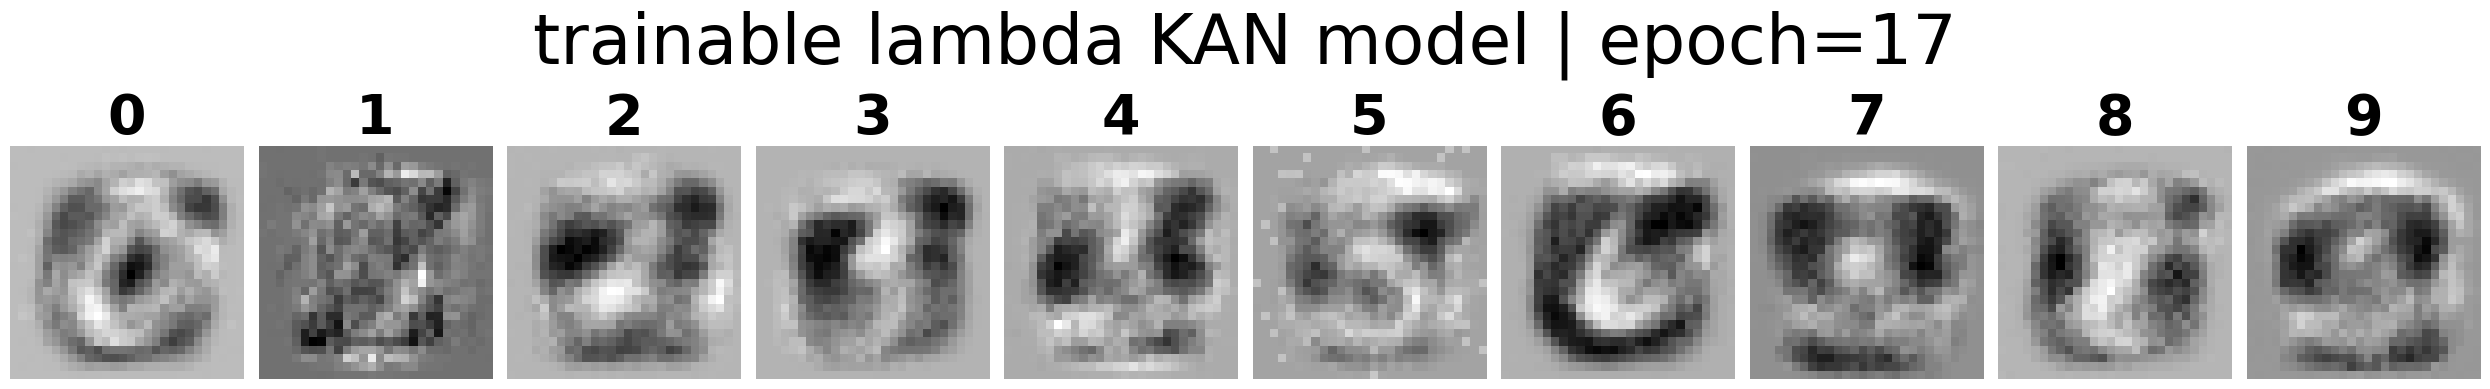

Epoch 17: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s, v_num=0, loss=0.094] Shape with bias: (784, 10)


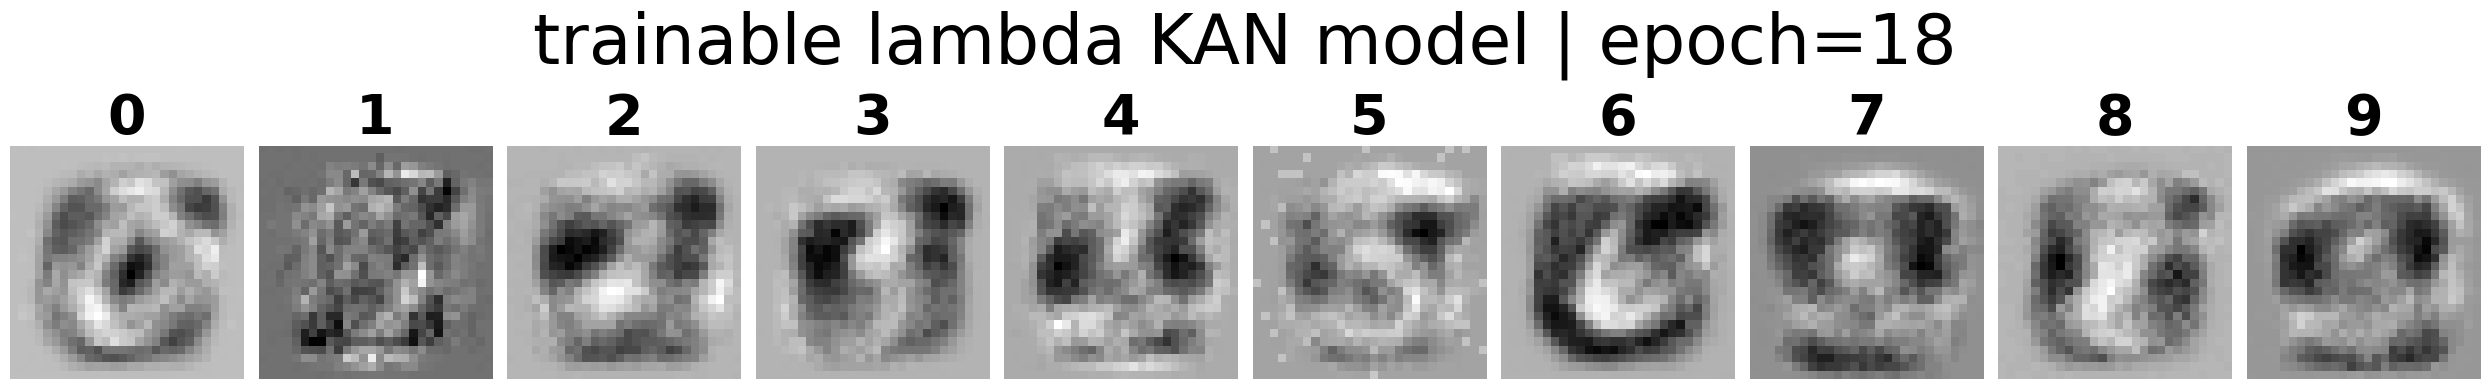

Epoch 18: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s, v_num=0, loss=0.0501]Shape with bias: (784, 10)


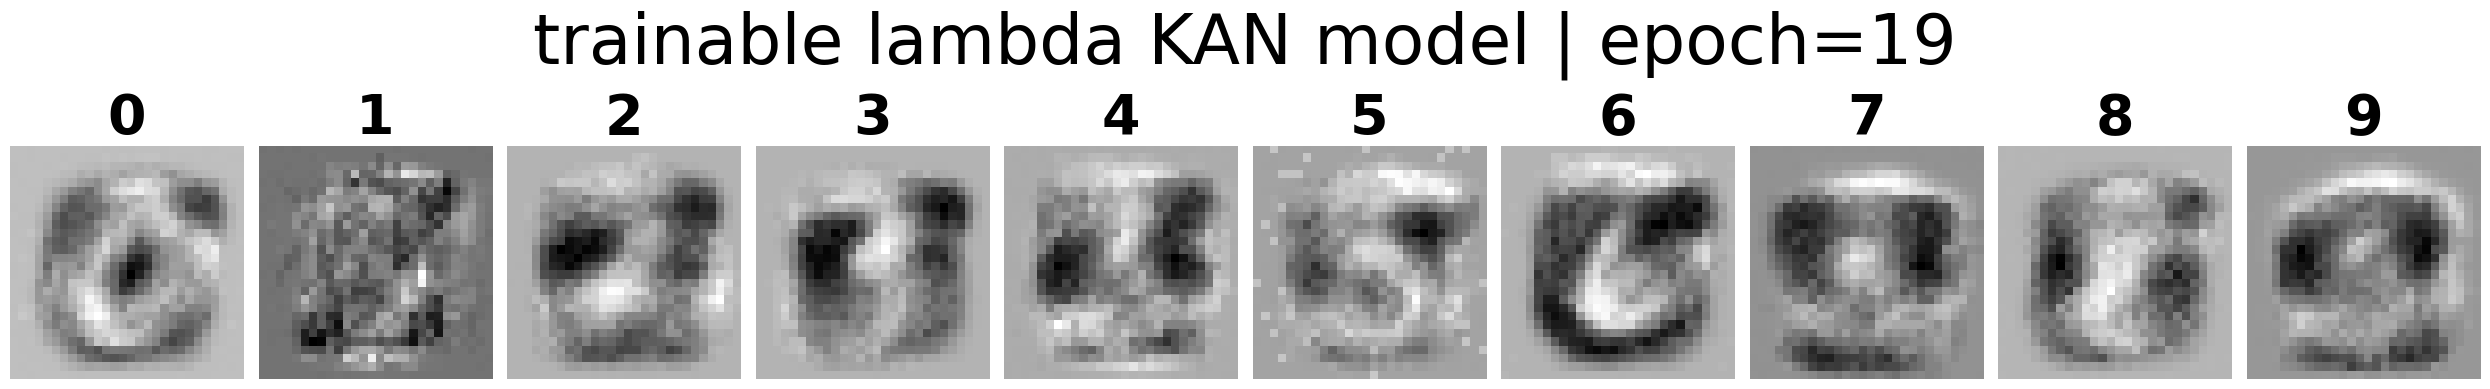

Epoch 19: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s, v_num=0, loss=0.0588]Shape with bias: (784, 10)


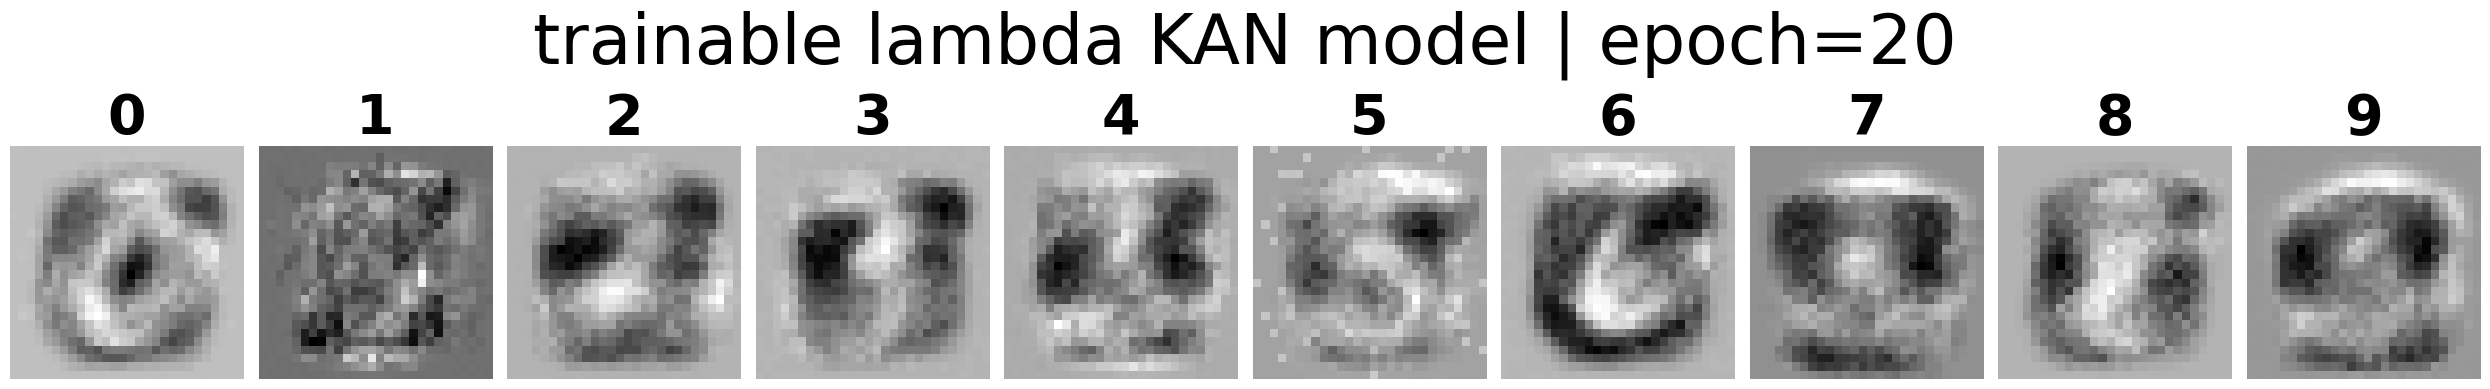

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s, v_num=0, loss=0.0588]


In [4]:
class LModel_save_pic(LModel):
    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()
        
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        
        directory = self.logger.log_dir + '\\sens_pic'
        if not os.path.exists(directory):
            os.makedirs(directory)
        show_sensitivity(W = self.model.get_W(),
                         title = f'trainable lambda KAN model | epoch={self.current_epoch+1}',
                         save_pic=True, 
                         file_path=directory + f'\\{self.current_epoch}.png')

checkpoint_callback = ModelCheckpoint(
    # dirpath='best_ckp/'
    save_last=True,
    every_n_epochs=1,
    save_top_k=1,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

L.seed_everything(1755)

model = Mnist_tlmdSplineKAN() #Mnist_lmdSplineKAN() #MnistPrllSplineKAN() #MnistSplineKAN() #MnistSplineKAN() #MnistKAN() #MnistMLP() #MnistCNN() #MnistLR()
pl_model = LModel_save_pic(model)
trainer = L.Trainer(
    max_epochs=20,
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir=f"./logs/{type(model).__name__}/"),
)

trainer.fit(
    model=pl_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

In [5]:
# Load the best checkpoint automatically (lightning tracks this for you)
trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True, ckpt_path="best"
)

Restoring states from the checkpoint path at ./logs/Mnist_tlmdSplineKAN/lightning_logs\version_0\checkpoints\model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./logs/Mnist_tlmdSplineKAN/lightning_logs\version_0\checkpoints\model.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.9591081142425537     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.9591081142425537}]

### Plot training curve, if needed

In [8]:
log_dir_LR = 'logs\\MnistLR\\lightning_logs\\version_0'
log_dir_MLP = 'logs\\MnistMLP\\lightning_logs\\version_0'
log_dir_lmdSplineKAN = 'logs\\Mnist_lmdSplineKAN\\lightning_logs\\version_0'
log_dir_tlmdSplineKAN = 'logs\\Mnist_tlmdSplineKAN\\lightning_logs\\version_0'

l_dirs = [log_dir_LR, log_dir_MLP, log_dir_lmdSplineKAN, log_dir_tlmdSplineKAN]
l_names = ['Linear Regression', 'MLP', 'lambda KAN', 'trainable lambda KAN']

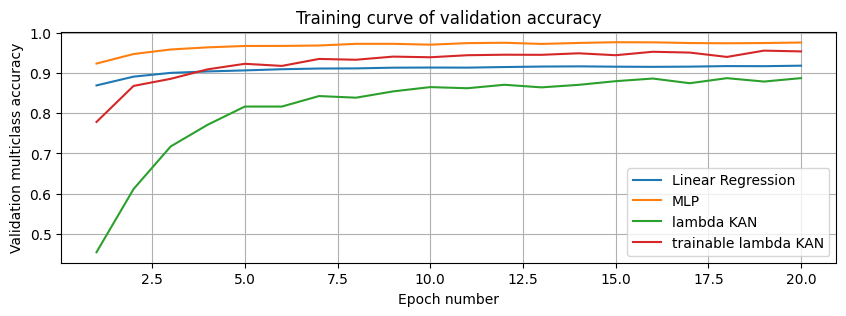

In [9]:
plt.figure(figsize=(10, 3))

for name, log_dir in zip(l_names, l_dirs):
    reader = SummaryReader(log_dir)
    df = reader.scalars

    def drop_nan(df, tag):
        return df[~df[tag].isna()].loc[:, tag]

    acc = drop_nan(df, "MulticlassAccuracy/val").values
    plt.plot(list(range(1, len(acc)+1)), acc, label=name)


plt.xlabel('Epoch number')
plt.ylabel('Validation multiclass accuracy')
plt.title("Training curve of validation accuracy")
plt.grid()
plt.legend(loc="lower right")
plt.show()